<a href="https://colab.research.google.com/github/dondoC34/Master-Thesis-Whole_Page_Optimization/blob/master/DMTM_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining and Text Mining Project
Sales Forecast
The training data are contained in train.csv file, let's give a look at how the data are structured and the available features.




In [50]:
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import seaborn as sns;
from scipy.stats import pearsonr;
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf;
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from itertools import combinations


from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics.scorer import make_scorer
from sklearn.tree import plot_tree


warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 100)

In [51]:
def MAPE(y_true, y_pred, **kwargs):
  y_t = np.array(y_true)
  y_p = np.array(y_pred)
  return round(np.mean(np.abs(y_t - y_p) / y_t), 3)

In [3]:
sales_data = pd.read_csv('/content/drive/My Drive/DMTM_Project_Data/train.csv')
for column in sales_data.columns:
  print(column)

Unnamed: 0
sku
pack
size (GM)
brand
price
POS_exposed w-1
volume_on_promo w-1
sales w-1
scope
target


The binary "scope" feature denotes which product we are required to predict their sales. For now we can consider only those products, identified by their SKUs (codes). 

In [4]:
sales_data = sales_data[sales_data["scope"] == 1]
sales_data.groupby("sku").describe()

size (GM)                                                                \
         count    mean           std     min     25%     50%     75%     max   
sku                                                                            
144      133.0  114.23  3.138208e-13  114.23  114.23  114.23  114.23  114.23   
546      133.0  114.23  3.138208e-13  114.23  114.23  114.23  114.23  114.23   
549      133.0  114.23  3.138208e-13  114.23  114.23  114.23  114.23  114.23   
554      133.0  114.23  3.138208e-13  114.23  114.23  114.23  114.23  114.23   
686      133.0  125.65  2.139687e-13  125.65  125.65  125.65  125.65  125.65   
688      133.0  125.65  2.139687e-13  125.65  125.65  125.65  125.65  125.65   
1027     133.0  114.23  3.138208e-13  114.23  114.23  114.23  114.23  114.23   
1035     133.0  114.23  3.138208e-13  114.23  114.23  114.23  114.23  114.23   
1051     133.0  125.65  2.139687e-13  125.65  125.65  125.65  125.65  125.65   
1058     133.0  125.65  2.139687e-13  125.65  125.65  125.65  125.65  125.65   
1065     133.0  125.65  2.139687e-13  125.65  125.65  125.65  125.65  125.65   
1206     133.0  125.65  2.139687e-13  125.65  125.65  125.65  125.65  125.65   

      price                                                   POS_exposed w-1  \
      count      mean       std   min   25%   50%   75%   max           count   
sku                                                                             
144   133.0  2.710150  0.696969  1.75  2.00  2.36  3.49  3.89           132.0   
546   133.0  0.496090  0.082763  0.33  0.41  0.54  0.56  0.59           132.0   
549   133.0  0.481053  0.094671  0.30  0.38  0.53  0.55  0.56           132.0   
554   133.0  0.500075  0.079530  0.34  0.42  0.54  0.56  0.59           132.0   
686   133.0  2.710301  0.695356  1.75  2.00  2.39  3.49  3.89           132.0   
688   133.0  0.487068  0.092800  0.31  0.39  0.53  0.56  0.57           132.0   
1027  133.0  0.487820  0.090674  0.31  0.39  0.53  0.56  0.57           132.0   
1035  133.0  0.481353  0.093596  0.31  0.38  0.53  0.55  0.56           132.0   
1051  133.0  2.715714  0.695328  1.75  2.00  2.42  3.49  3.89           132.0   
1058  133.0  0.485188  0.092782  0.31  0.39  0.53  0.56  0.57           132.0   
1065  133.0  0.502105  0.085067  0.33  0.42  0.54  0.56  0.65           132.0   
1206  133.0  0.495639  0.089072  0.32  0.41  0.53  0.56  0.65           132.0   

                                                       volume_on_promo w-1  \
           mean        std  min  25%  50%    75%   max               count   
sku                                                                          
144   17.727273  21.948618  0.0  0.0  5.0  40.50  63.0               132.0   
546    5.848485   9.253417  0.0  1.0  2.0   5.00  37.0               132.0   
549    3.234848   5.202553  0.0  0.0  1.0   4.00  23.0               132.0   
554    8.962121  12.459648  0.0  1.0  3.0   9.25  58.0               132.0   
686   21.257576  24.658467  0.0  0.0  7.0  51.00  70.0               132.0   
688    3.492424   5.608739  0.0  0.0  1.0   4.00  23.0               132.0   
1027   6.560606  10.483908  0.0  0.0  2.0   8.50  44.0               132.0   
1035   4.189394   8.148556  0.0  0.0  1.0   3.00  42.0               132.0   
1051  11.075758  14.366852  0.0  0.0  5.0  19.00  65.0               132.0   
1058   3.181818   5.021812  0.0  0.0  1.0   4.00  24.0               132.0   
1065   9.484848  13.038103  0.0  1.0  3.0   9.00  51.0               132.0   
1206   4.196970   7.494975  0.0  0.0  1.0   3.25  40.0               132.0   

                                                                         \
           mean        std        min        25%        50%         75%   
sku                                                                       
144   59.991075  47.128562   0.000000   2.709716  97.959306   99.817727   
546   50.596795  29.182086  10.041824  29.402507  38.516216   91.168735   
549   48.452436  34.026144   6.196853  24.

The fact that, for each sku code, we have exactly 133 samples available makes me think that the time series of sales, for each product, is composed by 133 samples and there are no missing dates. Let verify this point through a simple plot for sku 1027, for the target feature. Before to procede, we have to set the date as the index of each sample

In [5]:
for i, row in sales_data.iterrows():
  date = row["Unnamed: 0"]
  date_wo_day_of_week = date[3:] # Remove WE since all days of the week are the same
  sales_data.at[i, "Unnamed: 0"] = date_wo_day_of_week

sales_data["Unnamed: 0"] = pd.to_datetime(sales_data["Unnamed: 0"])

In [6]:
sales_data.set_index(sales_data["Unnamed: 0"], inplace=True)

In [7]:
sales_data.drop(columns="Unnamed: 0", axis=1, inplace=True)
sales_data.index.rename("date", inplace=True)

Consider, as an example, the product with **sku** = 1027:

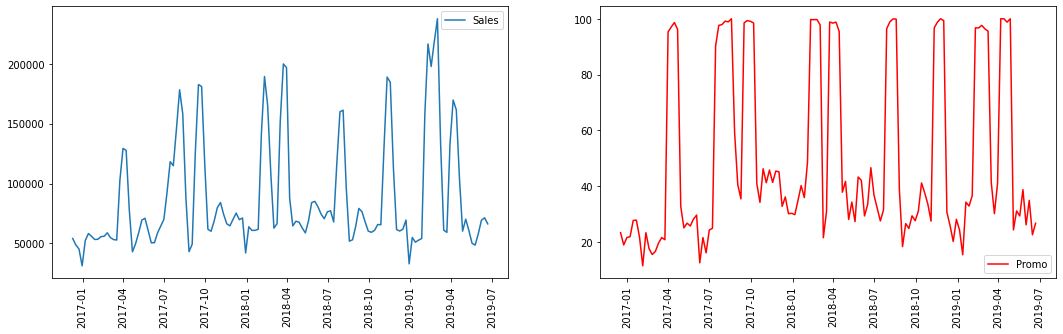

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(sales_data[sales_data["sku"] == 1027]["target"], label="Sales");
plt.xticks(rotation=90)
plt.legend()
plt.subplot(1,2,2)
plt.plot(sales_data[sales_data["sku"] == 1027]["volume_on_promo w-1"], label="Promo", color="red");
plt.xticks(rotation=90)
plt.legend();

It looks like that the peaks of promo products corresponds, as one may expect, to peaks of sales on the same week. **A seasonality of sales and promos can be easily noticed**. Let's then check the pearson correlation between these two time series:

In [8]:
sales_data_1027 = sales_data[sales_data["sku"] == 1027]
sales_data_1027 = sales_data_1027.dropna()
print("Pearson Coeff for sales on week W and promo volume for week W-1:", pearsonr(sales_data_1027["target"], sales_data_1027["volume_on_promo w-1"])[0])

Pearson Coeff for sales on week W and promo volume for week W-1: 0.6696570909947503


The Pearson coeff is not so high highlighting the fact that the two time series are not heavily correlated. This can be due to the fact that the sales and the promotion are referring to two different weeks. In particular, sales are on week W whereas the promotion takes place on week W-1. If we compare indeed the sales and the promotion on week W-1 the new Pearson coeff is:

In [ ]:
print("Pearson Coeff for sales on week W-1 and promo volume for week W-1:", pearsonr(sales_data_1027["sales w-1"], sales_data_1027["volume_on_promo w-1"])[0])

Pearson Coeff for sales on week W-1 and promo volume for week W-1: 0.8551663708800589


We may wonder that **the planned price for week W could influence the sales on week W**, that is the "target" we have to predict. In particular, the planned price can be viewed as a reflection of a possible promotion on the next week. Let's check this possible correlation through some plots:

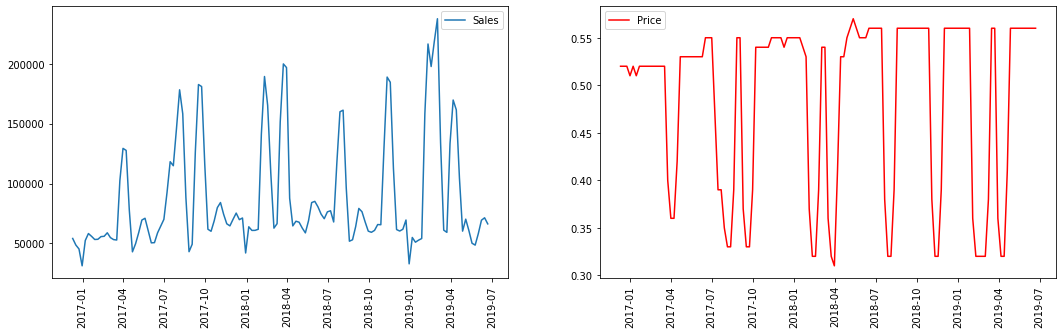

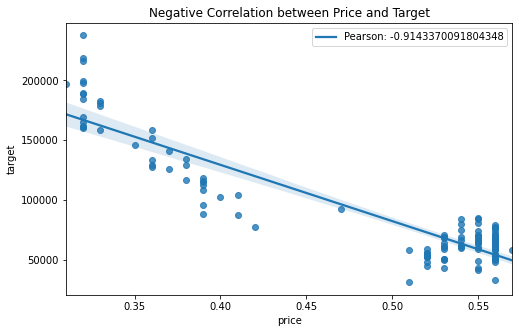

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(sales_data[sales_data["sku"] == 1027]["target"], label="Sales");
plt.xticks(rotation=90)
plt.legend()
plt.subplot(1,2,2)
plt.plot(sales_data[sales_data["sku"] == 1027]["price"], label="Price", color="red");
plt.xticks(rotation=90)
plt.legend()
plt.figure(figsize=(8, 5))
sns.regplot(x="price", y="target", data=sales_data[sales_data["sku"] == 1027])
plt.title("Negative Correlation between Price and Target");
p_coeff = pearsonr(sales_data[sales_data["sku"] == 1027]["price"], sales_data[sales_data["sku"] == 1027]["target"])
plt.legend(["Pearson: " + str(p_coeff[0])]);


It looks like that for low prices people buy more stuff (the negative correlation is clear also from the two plots of the corresponding time series). The planned price provides then us a useful insight on the possible amount of sales to be forecasted.
It has to be taken into account that the **price** feature is the planned price for the next week, that is, the week for which we have to predict the sales 
(target). As a consequence, **price** will give us a strong contribution for the prediction of target, having a strong negative correlation with it. 


---


For each sku, we plot here the correlation between each pair of numerical features, capturing all the useful correlation between them:


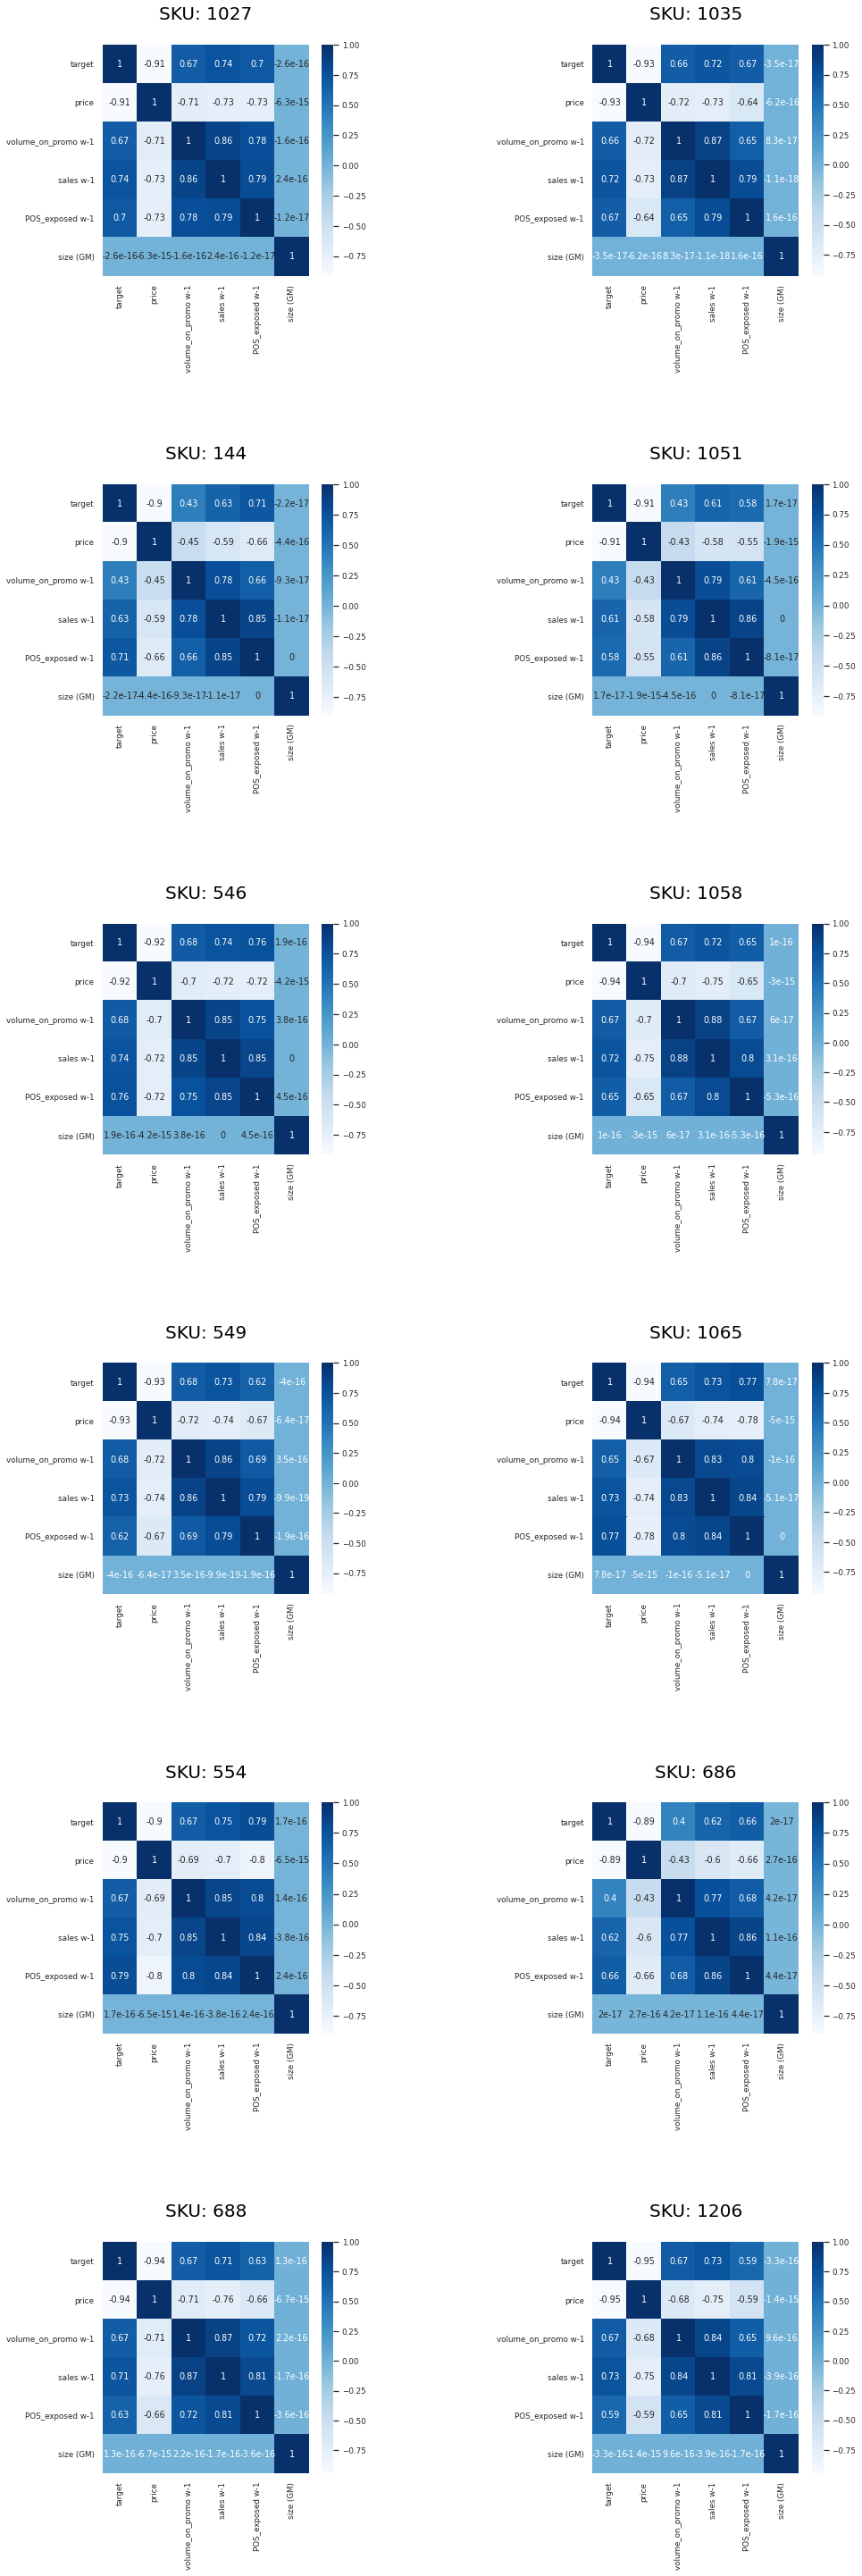

In [ ]:
fig = plt.figure(figsize=(15, 50))
fig.subplots_adjust(hspace=0.9, wspace=0.9)
sns.set(font_scale=0.8)
plot_nr = 1

for sku in sales_data["sku"].unique():
  correlations = sales_data[sales_data["sku"] == sku][["target", "price", "volume_on_promo w-1", "sales w-1", "POS_exposed w-1", "size (GM)"]].corr()
  ax = fig.add_subplot(6, 2, plot_nr)
  ax.set_title("SKU: " + str(sku) + "\n", fontdict={'fontsize':20, 'color':'black'})
  sns.heatmap(correlations, cmap="Blues", annot=True, ax=ax);
  plot_nr += 1

As can be noticed, the **price** feature constitutes the most correlated feature with **target** with respect to the remaining ones. This is due to the fact that **target** and **price** refer to the same week. By the way, we can conclude that **price** is a very good feature to predict the sales for each SKU. Furthermore:
*   **Sales w-1**, for 9 SKUs out of 12, is positive correlated with **target** with a pearson coefficient $\approx$ 0.7. We are going to check if past values of sales, like **Sales w-1**, **Sales w-2**... constitute good features to predict future values of Sales (**target**) (i.e., AR-like process),
*   **POS_exposed w-1**, may influence future values of Sales since more people see that product on the previous week. By the way, the correlation is not always "strong" among different SKUs. Similarly, we can argue the correlation between **target** and **volume_on_promo w-1**. In conclusion, these features MAY provide some help in prediction, we will check these points later,
*   **size (GM)**, that is, the product weight, is not correlated for any SKU, therefore we are not going to use it for prediction.

---

Since i am predicting sales of different products (each defined by an **sku**), i am thinking to build different models, one for each **sku**. In particular, we can observe that there are no products, with the same **sku**, which have (obviously) two or more brands, but, interestingly, there are no products which share the same **sku** but have a different packaging, that is, each **sku** has a single packaging:




In [ ]:
sales_data.groupby("sku")["pack"].unique()

sku
144      [MULTI]
546     [SINGLE]
549     [SINGLE]
554     [SINGLE]
686      [MULTI]
688     [SINGLE]
1027    [SINGLE]
1035    [SINGLE]
1051     [MULTI]
1058    [SINGLE]
1065    [SINGLE]
1206    [SINGLE]
Name: pack, dtype: object

By the way, if products which share the same **pack** or the same **brand** share a similar time series for **target**, we can use a single model to learn them all. Then we can use each **sku** to shift up or down the time series we learnt to correctly predict the sales for that product. We can check now if products, which share the same **pack** feature, show a similar time series of targets:

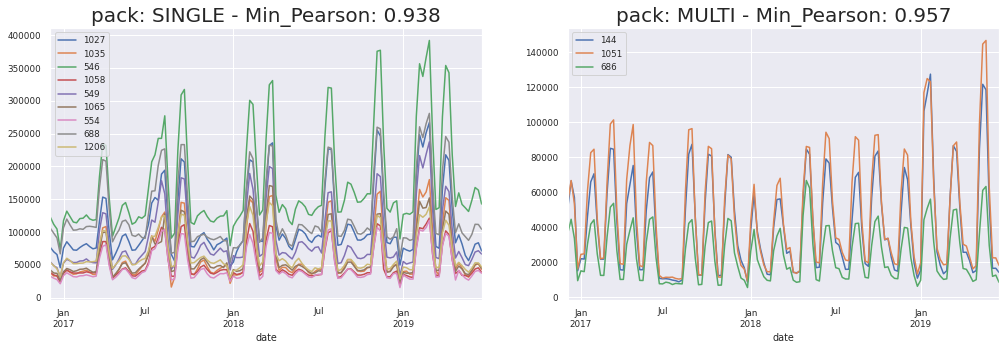

In [ ]:
sales_data_multi = sales_data[sales_data["pack"] == "MULTI"]
sales_data_single = sales_data[sales_data["pack"] == "SINGLE"]
fig= plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 2, 1)
sku_combs = combinations(sales_data_single["sku"].unique(), 2)
pearsons_coeff = []
for sku_comb in sku_combs:
  pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0]]["target"], sales_data[sales_data["sku"] == sku_comb[1]]["target"])[0])
ax.set_title("pack: SINGLE - Min_Pearson: " + str(round(np.min(np.abs(pearsons_coeff)), 3)), fontdict={"fontsize":20})
sales_data_single.groupby("sku")["target"].plot(ax=ax, figsize=(17, 5));
ax.legend(sales_data_single["sku"].unique())
ax = fig.add_subplot(1, 2, 2)
sku_combs = combinations(sales_data_multi["sku"].unique(), 2)
pearsons_coeff = []
for sku_comb in sku_combs:
  pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0]]["target"], sales_data[sales_data["sku"] == sku_comb[1]]["target"])[0])
ax.set_title("pack: MULTI - Min_Pearson: " + str(round(np.min(np.abs(pearsons_coeff)), 3)), fontdict={"fontsize":20})
sales_data_multi.groupby("sku")["target"].plot(ax=ax, figsize=(17, 5));
ax.legend(sales_data_multi["sku"].unique());


Seemingly, products which share the same **pack** present the same sales time series, as it is shown by the minimum pearson's coefficient among all the pairs (that means, the sales of product which share the same pack present the same peaks, and also the same general behaviour). We could build a single model, one for **pack: SINGLE** products and the other for **pack:MULTI**, each model then can use the information given by the **sku** of the product we are predicting the sales to adjust the prediction, shifting it up or down. As an example, for **pack:SINGLE** we can observe that products 554 and 1058 present almost exactly the same time series, therefore the model will not discriminate so much between these two. On the other hand, the time series for product 546 can be approximated by just shifting up the 544 one. 

---

Let's perform the same analysis with **brand**, we have two different brands:

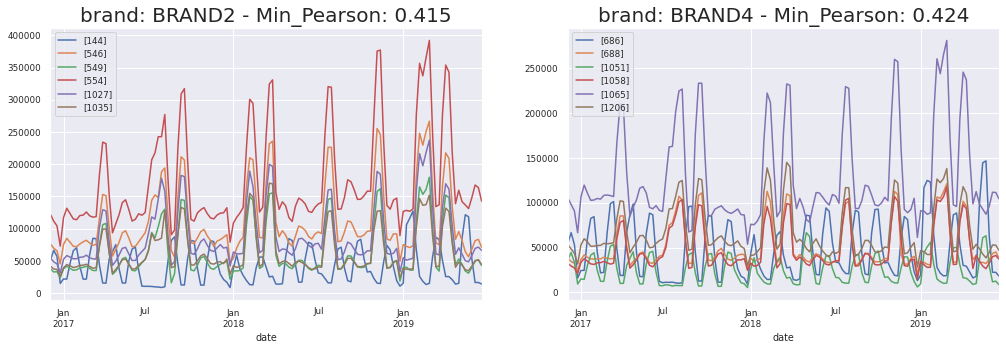

In [ ]:
sales_data_brand2 = sales_data[sales_data["brand"] == "BRAND2"].groupby("sku")
sales_data_brand4 = sales_data[sales_data["brand"] == "BRAND4"].groupby("sku")
fig= plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 2, 1)
sku_combs = combinations(sales_data_brand2["sku"].unique(), 2)
pearsons_coeff = []
for sku_comb in sku_combs:
  pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0][0]]["target"], sales_data[sales_data["sku"] == sku_comb[1][0]]["target"])[0])
ax.set_title("brand: BRAND2 - Min_Pearson: " + str(round(np.min(np.abs(pearsons_coeff)), 3)), fontdict={"fontsize":20})
sales_data_brand2["target"].plot(ax=ax, figsize=(17, 5))
ax.legend(sales_data_brand2["sku"].unique())
ax = fig.add_subplot(1, 2, 2)
sku_combs = combinations(sales_data_brand4["sku"].unique(), 2)
pearsons_coeff = []
for sku_comb in sku_combs:
  pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0][0]]["target"], sales_data[sales_data["sku"] == sku_comb[1][0]]["target"])[0])
ax.set_title("brand: BRAND4 - Min_Pearson: " + str(round(np.min(np.abs(pearsons_coeff)), 3)), fontdict={"fontsize":20})
sales_data_brand4["target"].plot(ax=ax, figsize=(17, 5));
ax.legend(sales_data_brand4["sku"].unique());

For what concerns brands, seasonalities seems to be related, with the exception of **sku**:144 for BRAND2 and of **sku**s 686 and 1051 for BRAND4. Indeed, the seasonalities presented by the latters appears to be unrealed with the other products with the same **brand** and for this reason the minimun Pearson's coefficient drop significantly w.r.t. the previous case. For this reason, we cannot learn a model for all of those products which share the same **brand** in the same way we did for the **pack** feature.

---

Finally, we can check whether the time series of **target** are related for those products which share the same brand and the same **pack**:

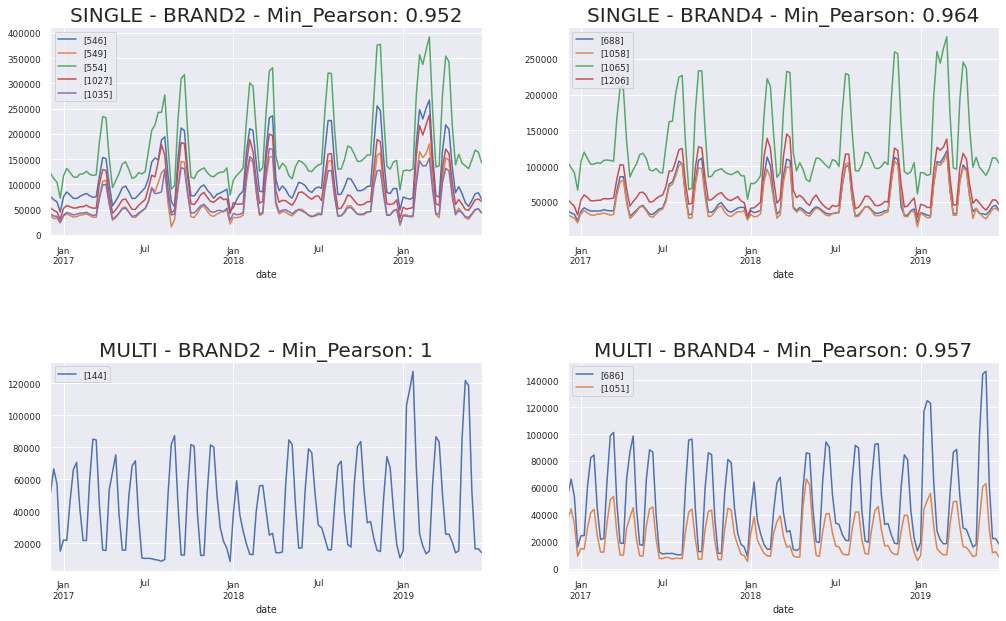

In [ ]:
combs = list(combinations(["SINGLE", "MULTI", "BRAND2", "BRAND4"], 2))
feasible_combs = []
for elem in combs:
  if (elem != ("SINGLE", "MULTI")) and (elem != ("BRAND2", "BRAND4")):
    feasible_combs.append(list(elem))

fig = plt.figure(figsize=(20, 12))
fig.subplots_adjust(hspace=0.6)
index = 1

for comb in feasible_combs:
  sales_comb = sales_data[(sales_data["pack"] == comb[0]) & (sales_data["brand"] == comb[1])]
  sales_comb = sales_comb.groupby("sku")
  ax = fig.add_subplot(2, 2, index)
  sales_comb["target"].plot(ax=ax, figsize=(17, 10))
  ax.legend(sales_comb["sku"].unique())
  sku_combs = combinations(sales_comb["sku"].unique(), 2)
  pearsons_coeff = []
  for sku_comb in sku_combs:
    pearsons_coeff.append(pearsonr(sales_data[sales_data["sku"] == sku_comb[0][0]]["target"], sales_data[sales_data["sku"] == sku_comb[1][0]]["target"])[0])
  try:
    ax.set_title(comb[0] + " - " + comb[1] + " - Min_Pearson: " + str(round(np.min(pearsons_coeff), 3)) , fontdict={"fontsize":20})
  except ValueError:
    ax.set_title(comb[0] + " - " + comb[1] + " - Min_Pearson: 1" , fontdict={"fontsize":20})

  index += 1


If we would follow this separation, we will learn four different models, one for each possible combinations, since all of them show time series which are significantly related. We will determine whether learn four models (following this approach), rather than two (following the **pack** separation approach), introduce an improve of performances. In the end, we can also check whether learning a model for each product is worth it it practice.

---

From the previous plots, we can notice some products which, in general, show a single seasonality, like 144, 686 and 1051. On the other hand, products like 554 seemingly show multiple seasonalitites. Models like SARIMAX can handle a single seasonality, let's briefly analyze product 144's time series of sales before trying to apply such a model:

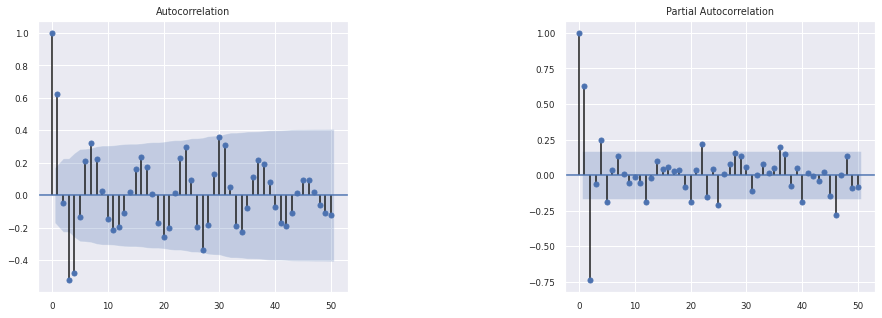

In [ ]:
sales_data_144 = sales_data[sales_data["sku"] == 144]
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.7)
ax = fig.add_subplot(1, 2, 1)
plot_acf(sales_data_144["target"], ax=ax, lags=50)
ax = fig.add_subplot(1, 2, 2)
plot_pacf(sales_data_144["target"], ax=ax, lags=50)
plt.show();

From the autocorrelation and partial autocorrelation plots, it is easy to see the seasonality present in the **target** time series. We can try to use a SARIMAX model and identify the seasonal component with period equal to three, that is, three weeks. To determine the best SARIMAX parameters set, which is composed by 7 parameters, we can explore a little subset of this parameters-space and use a train/test sets:

In [ ]:
# Takes about 1 hour
models_aic = []
models_aic.sort(key=lambda x: x[1], reverse=True)
exog = np.array(sales_data_144["price"][115:]).reshape(-1, 1)
for ar in range(0, 5):
  for i in range(0, 3):
    for ma in range (0, 5):
      for ar_s in range(0, 3):
        for i_s in range(0, 2):
          for ma_s in range(0, 3):
            for m in [2, 3, 4, 5]:
              sarimax_model = SARIMAX(sales_data_144["target"][: 115], order=(ar, i, ma), seasonal_order=(ar_s, i_s, ma_s, m), exog=sales_data_144["price"][0:115])
              try:
                trained_sarimax = sarimax_model.fit()
                residuals = trained_sarimax.resid
              except Exception:
                continue
              aic = trained_sarimax.aic
              bic = trained_sarimax.bic
              predictions = trained_sarimax.predict(start=115, end=132, exog=exog)
              mape = MAPE(sales_data_144["target"][115::], predictions)
              res_mean = np.mean(residuals)
              res_var = np.var(residuals)
              models_aic.append([ar, i, ma, ar_s, i_s, ma_s, m, aic, bic, res_mean, res_var, mape])

models_data = pd.DataFrame(models_aic, columns=["AR", "I", "MA", "AR_s", "I_s", "MA_s", "m", "AIC", "BIC", "Residuals' Mean", "Residuals' Variance", "MAPE"]).sort_values(by=["MAPE"], ascending=True)
models_data.head(10)

,AR,I,MA,AR_s,I_s,MA_s,m,AIC,BIC,Residuals' Mean,Residuals' Variance,MAPE
3623,3,1,0,1,0,0,2,2487.396071,2503.813262,1486.178356,2.741729e+08,0.163
3650,3,1,0,2,0,0,5,2489.381663,2508.535052,1560.945247,2.738552e+08,0.164
3610,3,1,0,0,0,2,5,2489.422228,2508.575617,1569.680296,2.738829e+08,0.165
3634,3,1,0,1,0,2,5,2491.403847,2513.293434,1565.730177,2.738703e+08,0.165
456,0,1,1,1,0,0,2,2484.403207,2495.348001,1470.842665,2.754990e+08,0.166
3606,3,1,0,0,0,1,5,2488.435652,2504.852843,1467.776325,2.755098e+08,0.167
3654,3,1,0,2,0,1,5,2491.366278,2513.255866,1554.035897,2.738552e+08,0.167
3630,3,1,0,1,0,1,5,2490.017421,2509.170810,1552.070673,2.747163e+08,0.168
2543,2,1,0,1,0,0,2,2485.420337,2499.101330,1458.663536,2.742804e+08,0.168
364,0,1,0,0,0,1,2,2482.121548,2490.330143,1453.355881,2.749640e+08,0.169


The first two model with the best performances seems to consider only the seasonal part of the model. We can use, for our purposes, the model with index **3623**:

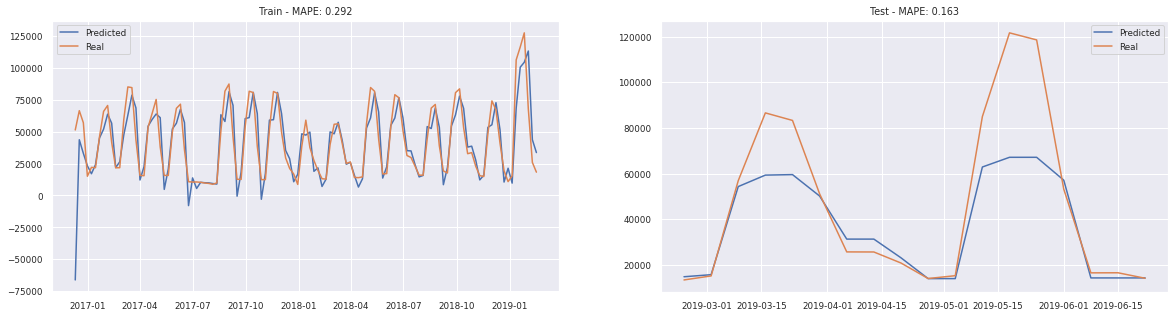

In [ ]:
sarimax_model = SARIMAX(sales_data_144["target"][: 115], order=(3, 1, 0), seasonal_order=(1, 0, 0, 2), exog=sales_data_144["price"][0:115])
trained_sarimax = sarimax_model.fit()
exog = np.array(sales_data_144["price"][115:]).reshape(-1, 1)
train_predictions = trained_sarimax.predict(start=-115, exog=exog)
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(train_predictions)
ax.plot(sales_data_144["target"][0:115])
ax.legend(["Predicted", "Real"])
mape = MAPE(sales_data_144["target"][0:115], train_predictions)
ax.set_title("Train - MAPE: " + str(mape))
predictions = trained_sarimax.predict(start=115, end=132, exog=exog)
ax = fig.add_subplot(1, 2, 2)
ax.plot(predictions)
ax.plot(sales_data_144["target"][115::])
ax.legend(["Predicted", "Real"])
mape = MAPE(sales_data_144["target"][115::], predictions)
ax.set_title("Test - MAPE: " + str(mape))
plt.show()

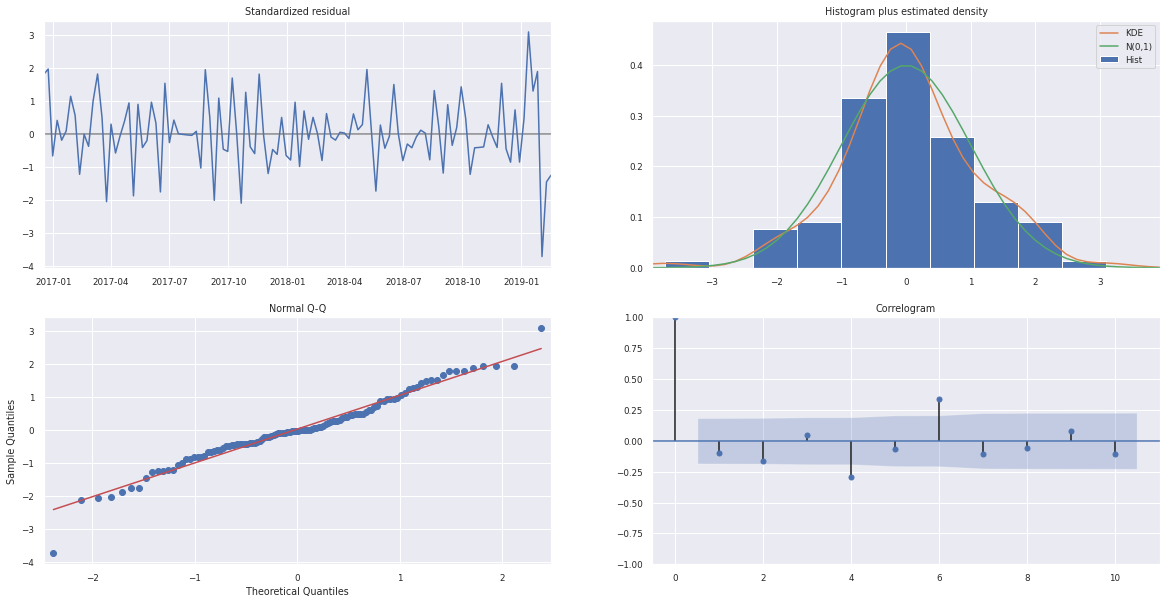

In [ ]:
trained_sarimax.plot_diagnostics(figsize=(20, 10))
plt.show();

From the correlogram of the residuals, we can notice that not all the information is captured by our model, since for multiple lags the residuals appear to be correlated. Furthermore, the distribution of the residuals is clearly a non-standard normal distribution, that is, the prediction error is not a white noise. As a consequence, there may be some information left in the prediction error which is not captured by the model. 

Pay attention to the fact that the resulting parameter for I is equal to zero, as could be expected. Indeed, the adfuller test allows us to reject the hypothesis of this series to be a random walker with confidence 95%. Here's the p-value:

In [ ]:
p_value = adfuller(sales_data_1027["target"])[1]
print("Adfuller p-value:", p_value)

Adfuller p-value: 3.2144757295957615e-05


Is interesting now to observe whether previous lags of the other features consitute a good set of features to predict the **target**. To do so, we can first add the past five (but it can be more) lags  of each feature, then fit a Lasso model that will give us help in terms of features selection.

---

# SKU 144 for Features Analysis and Models Testing

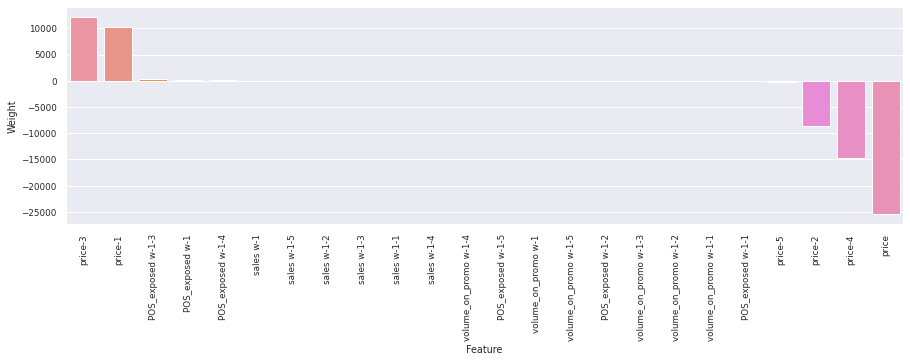

In [ ]:
# add previous lags of all the numeric features, except for size (GM), that is useless for our purposes
for feature in ["price", "POS_exposed w-1", "volume_on_promo w-1", "sales w-1"]:
  for lag in range(1, 6):
    sales_data_144[feature + "-" + str(lag)] = sales_data_144[feature].shift(lag)

sales_data_144.dropna(inplace=True)
selected_features = []
for column in sales_data_144.columns:
  if (column != "sku") and (column != "target") and (column != "size (GM)") and \
     (column != "brand") and (column != "pack") and (column != "scope"):
     selected_features.append(column)
selected_features.sort(reverse=False)

lasso_model = Lasso(alpha=0.01, max_iter=5000, random_state=12323)
lasso_model.fit(X=sales_data_144[selected_features], y=sales_data_144["target"])
lr_coefficients = pd.DataFrame({'Variable':selected_features, 'Coefficient':lasso_model.coef_}).sort_values(by=['Coefficient'],ascending=False)
plt.figure(figsize=(15, 4))
sns.barplot(x='Variable',y='Coefficient',data=lr_coefficients);
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Weight");

It seems that only the **price** feature, with all its lags, is relevant feature selection-wise. Actually, as already discussed, **price** constitutes a really good predictive feature; the reason why **price** got the highest weights is because the range of **price** values is (1.75, 3.89) (as can be verified by using the proper pandas' methods) whereas the **target** values' range is (8653, 127418). Therefore, to predict **target** the model has to assign high weights to **price** lags. On the contrary, to feature like **sales w-1**, which has the same scale as **target**, lower weights are assigned, but this fact does not mean that **price w-1** is not important in the prediction. To have a clearer vision of the features' contributes to prediction, let's normalize the data-set:

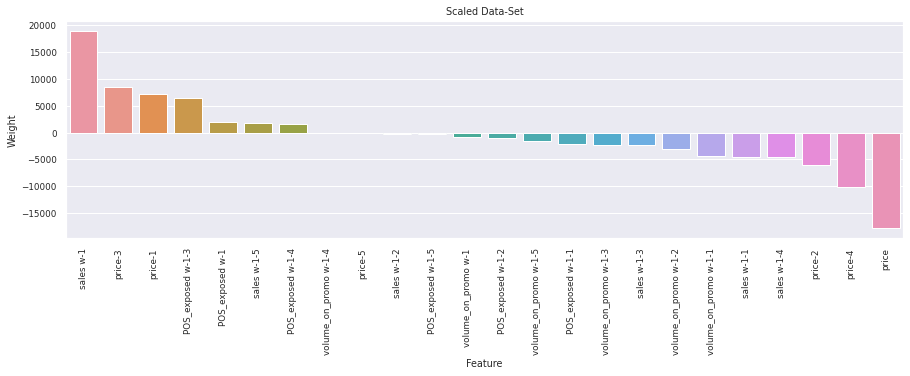

In [ ]:
std_scaler = StandardScaler()
scaled_sales_data_144 = std_scaler.fit_transform(X=sales_data_144[selected_features])

# fit a new Lasso model for features selection with the normalize data frame
lasso_model = Lasso(alpha=0.01, max_iter=5000, random_state=12323)
lasso_model.fit(X=scaled_sales_data_144, y=sales_data_144["target"])
lr_coefficients = pd.DataFrame({'Variable':selected_features, 'Coefficient':lasso_model.coef_}).sort_values(by=['Coefficient'],ascending=False)
plt.figure(figsize=(15, 4))
sns.barplot(x='Variable',y='Coefficient',data=lr_coefficients);
plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.title("Scaled Data-Set")
plt.ylabel("Weight");

Here we have a more clear vision of the contributions of all the features. We can try to train our first linear model, considering only those features which have a weight that is higher, in module, than a given threshold $\delta$ in the previous analysis. Let's try with different values of $\delta$ with a train, validation and test approach.
#Baseline: Ridge Regression
As a baseline we choose to use Ridge Regression with different polinomyal degrees. We are going to evaluate the performances of all the models with the walk-forward cross-validation.

In [66]:
# Given an estimator, a star date on which to start validate, a dataset (typically a pandas dataframe), a set of input
# features, the target_feature to be predicted and EVENTUALLY a polynomial degree for Linear Models, computes the
# MAPE error according to the walk-forward cross-validation
def walk_forward_x_validation(estimator, start_date, data, features, target_feature, poly_degree=None, verbose=False):
  dates = list(data[start_date:].index.unique())
  mapes = []
  predictions_list = []
  for k in range(len(dates) - 1):
    curr_date = str(dates[k].year) + "-" + str(dates[k].month) + "-" + str(dates[k].day)
    next_date = str(dates[k + 1].year) + "-" + str(dates[k + 1].month) + "-" + str(dates[k + 1].day)
    if poly_degree is None:
      estimator.fit(X=data[features][:curr_date], y=data[target_feature][:curr_date])
      predictions = estimator.predict(X=data[features][next_date:next_date])
    else:
      transformer = PolynomialFeatures(degree=poly_degree, include_bias=False)
      poly_input = transformer.fit_transform(X=data[features][:curr_date])
      estimator.fit(X=poly_input, y=data[target_feature][:curr_date])
      poly_input_test = transformer.fit_transform(X=data[features][next_date:next_date])
      predictions = estimator.predict(X=poly_input_test)

    predictions_list.append(predictions)
    mape = MAPE(data[target_feature][next_date:next_date], predictions)
    mapes.append(mape)
    if verbose:
      print(next_date, mape)

  predictions_frame = pd.DataFrame(predictions_list, columns=data["sku"].unique())
  predictions_frame.set_index(data[str(dates[1].year) + "-" + str(dates[1].month) + "-" + str(dates[1].day):].index.unique(), inplace=True)
  return np.mean(mapes), predictions_frame

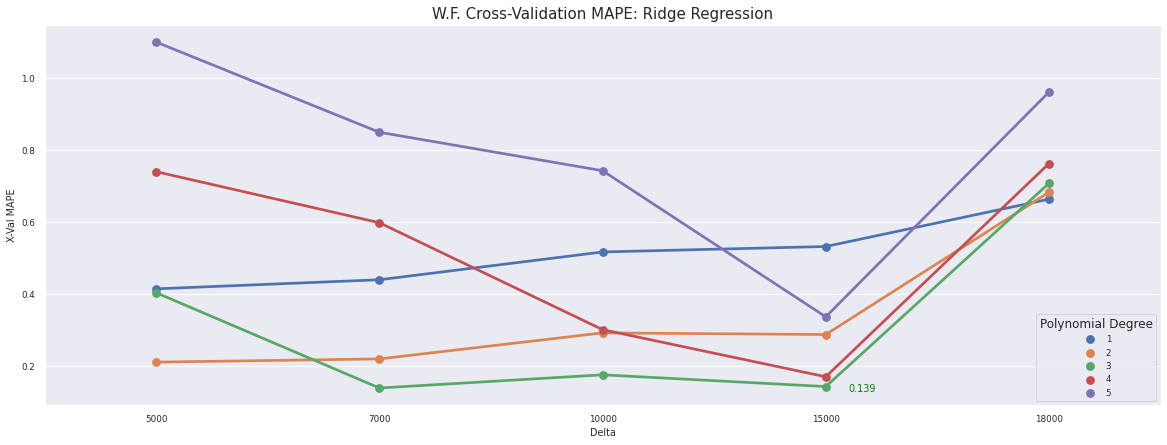

In [ ]:
deltas = [5000, 7000, 10000, 15000, 18000]
polynomial_degrees = [1, 2, 3, 4, 5]
mape_on_validation = []
for delta in deltas:
  for degree in polynomial_degrees:
    delta_features = lr_coefficients[(lr_coefficients["Coefficient"] > delta) | (lr_coefficients["Coefficient"] < -delta)]["Variable"]
    linear_model = Ridge(alpha=100)
    cv_mape, predictions = walk_forward_x_validation(estimator=linear_model, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_144,
                                        features=delta_features,
                                        target_feature="target",
                                        poly_degree=degree)
    
    mape_on_validation.append([delta, degree, cv_mape])

delta_performance = pd.DataFrame(mape_on_validation, columns=["Delta", "Polynomial Degree", "X-Val MAPE"]).sort_values(by=['X-Val MAPE'], ascending=True)
plt.figure(figsize=(20, 7))
plt.title("W.F. Cross-Validation MAPE: Ridge Regression", fontdict={"fontsize":15})
plt.text(3.1, 0.13, "0.139", fontdict={"color":"green"})
sns.pointplot(x="Delta", y="X-Val MAPE", data= delta_performance, hue="Polynomial Degree");

We can choose the best result we obtained, that is the model with polynomial degree equal to three, fed with the set of features determined by $\delta=15000$. Using a lot of features (i.e. for $\delta < 200$) and an higher polynomial degree we get worse results: this is due to the fact that some of those features are just noise if combined in polynomials. With a sufficient high value of $\alpha$ and an higher $\delta$ we are able to reach a baseline performance given by a MAPE $\approx 0.139$. Please note that linear models with input polynomials with degrees 1 and 2 perform better for small values of $\delta$ (MAPE $\approx0.175$), whereas models with higher polynomial degrees, like 3, 4, 5, perform very badly.

---

# Random Forests
We can now try a more complex model, such as Random Forests. We have to take into account that, regression-wise, Random Forests present a problem: they cannot predict values higher than values the have seen in the training set, and lower respectively. This is due to the fact that tree-based models associate at each leaf a value for regression, and leaf-values are determined during the training-phase. Even though for some **sku**s this problem take place in the training set (i.e. for product 144, two of the three last peaks are the highest among all of those in the training set), we assume that in the actual test set (test.csv file) the values of **target** are covered by the values in the training set. 

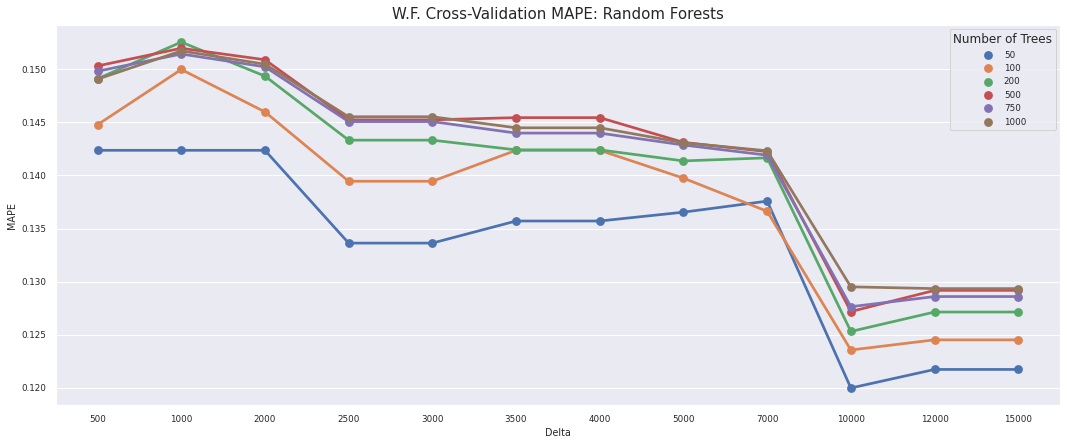

In [ ]:
deltas = [500, 1000, 2000, 2500, 3000, 3500, 4000, 5000, 7000, 10000, 12000, 15000]
trees = [50, 100, 200, 500, 750, 1000]
mape_on_validation = []
for delta in deltas:
  for trees_nr in trees:
    delta_features = lr_coefficients[(lr_coefficients["Coefficient"] > delta) | (lr_coefficients["Coefficient"] < -delta)]["Variable"]
    forest = RandomForestRegressor(n_estimators=trees_nr, random_state=1234, min_samples_split=2)
    cv_mape, predictions = walk_forward_x_validation(estimator=forest, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_144,
                                        features=delta_features,
                                        target_feature="target")
    mape_on_validation.append([delta, trees_nr, cv_mape])

delta_performance = pd.DataFrame(mape_on_validation, columns=["Delta", "Number of Trees", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(18, 7))
plt.title("W.F. Cross-Validation MAPE: Random Forests", fontdict={"fontsize":15})
sns.pointplot(x="Delta", y="MAPE", data= delta_performance, hue="Number of Trees");

The performances, according to walk forward x-validation are similar for different values of $\delta$. We choose $\delta = 5000$:

With respect to the baseline, we improve the performance of 6%, MAPE-wise. Yet, the problem regarding regression with trees-based approaches is present.

---
# Gradient Boosting
Seemingly, the trees-based approach with Random Forests in promising. Let's try another ensemble method based on tree-estimators.

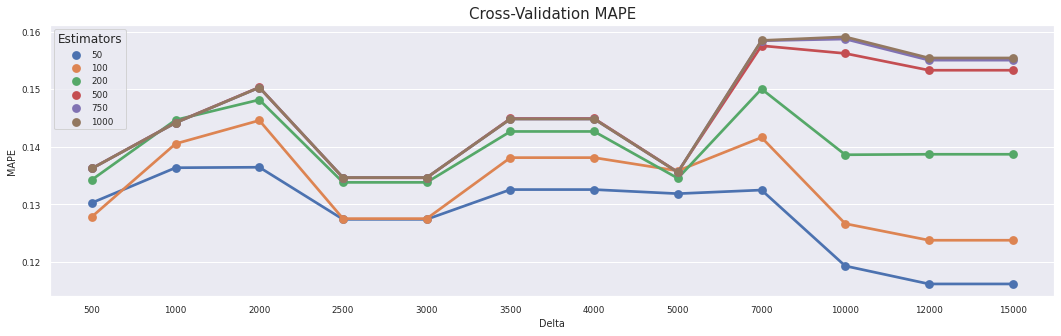

In [ ]:
deltas = [500, 1000, 2000, 2500, 3000, 3500, 4000, 5000, 7000, 10000, 12000, 15000]
num_of_trees = [50, 100, 200, 500, 750, 1000]
mape_on_validation = []
for delta in deltas:
  for trees in num_of_trees:
    delta_features = lr_coefficients[(lr_coefficients["Coefficient"] > delta) | (lr_coefficients["Coefficient"] < -delta)]["Variable"]
    boost = GradientBoostingRegressor(n_estimators=trees, random_state=1234, alpha=0.1)
    cv_mape, predictions = walk_forward_x_validation(estimator=boost, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_144,
                                        features=delta_features,
                                        target_feature="target")
    mape_on_validation.append([delta, trees, cv_mape])

delta_performance = pd.DataFrame(mape_on_validation, columns=["Delta", "Estimators", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(18, 5))
plt.title("Cross-Validation MAPE", fontdict={"fontsize":15})
sns.pointplot(x="Delta", y="MAPE", data= delta_performance, hue="Estimators");

As it is shown, the MAPE on the x-validation tends to be higher if to less features are considered ($\delta > 5000$). By the way, for deltas $\in (0, 5000)$ the models perform similarly and, the resulting MAPEs are comparable to those obtained with Random Forests.

---
# Decision Tree Regressors
Lastly, we try to move from trees-ensembles to a single tree to predict the sales and see whether the performance are still acceptable. We can reduce the Decision Trees' overfitting by tuning the **min_samples_split** parameter.

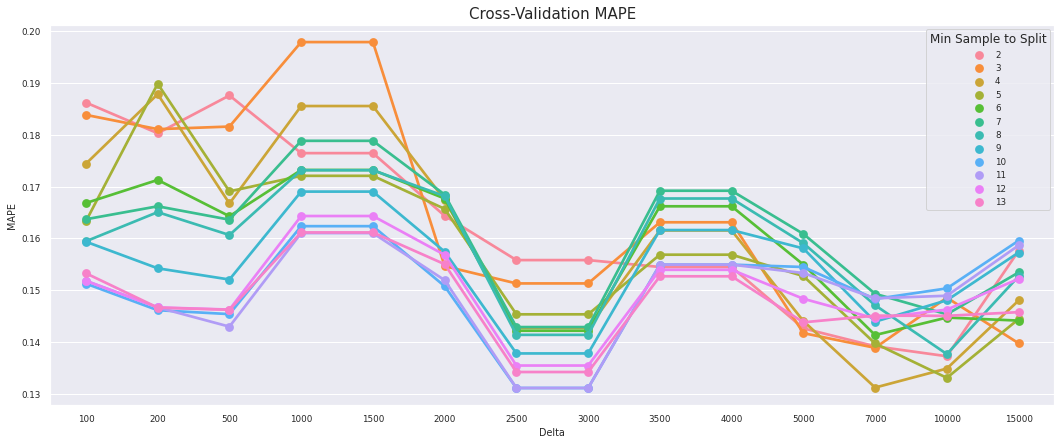

In [ ]:
deltas = [100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000, 7000, 10000, 15000]
min_split = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
mape_on_validation = []
for delta in deltas:
  for sample_split in min_split:
    delta_features = lr_coefficients[(lr_coefficients["Coefficient"] > delta) | (lr_coefficients["Coefficient"] < -delta)]["Variable"]
    tree = DecisionTreeRegressor(random_state=12345, min_samples_split=sample_split)
    cv_mape, predictions = walk_forward_x_validation(estimator=tree, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_144,
                                        features=delta_features,
                                        target_feature="target")
    mape_on_validation.append([delta, sample_split, cv_mape])

delta_performance = pd.DataFrame(mape_on_validation, columns=["Delta", "Min Sample to Split", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(18, 7))
plt.title("Cross-Validation MAPE", fontdict={"fontsize":15})
sns.pointplot(x="Delta", y="MAPE", data= delta_performance, hue="Min Sample to Split");

Even though the performance are similar across different values of samples contained into an internal node to perform a split, we can notice how incrementing this value we can improve the performance of the model. Indeed, leaves which contains just one or few more samples are likely to cause the model to overfit. With leaves containing a sufficient number of samples, we incentivize generalization. Finally, for $\delta \in (1000, 2000)$, the performance achieved by Regression Trees are comparable to those obtained from Ridge regression.

---
# Packaging-Based Sales Prediction
As we have previously shown, it seems that products which share the same type of **pack** (that is: SINGLE, MULTI), share a similar **target** time series as well. In particular, if we split the products according to their **pack** type we obtain:

* SINGLE **sku**s: 546, 549, 554, 688, 1027, 1035, 1058, 1065, 1206.
* MULTI **sku**s: 144, 686, 1051.

We could feed a model with the **sku** feature, for each **pack**, the model should be able to separate the two types of **target** time series basing on **pack**, then use the **sku** one-hot encoded to shift the corresponding time series and make the prediction. 



In [ ]:
# add previous lags of all the numeric features, except for size (GM), for all the SKUs
sales_data.fillna(method="bfill", inplace=True)
for feature in ["price", "POS_exposed w-1", "volume_on_promo w-1", "sales w-1"]:
  for lag in range(1, 6):
    sales_data[feature + "-" + str(lag)] = sales_data[feature].shift(lag)
# Remove the nan values or values of previous lags coming from other products
sales_data = sales_data["2017-01-14":]
sales_data.drop(columns=["brand", "size (GM)", "scope"], axis=1, inplace=True)
sales_data["sku"] = sales_data["sku"].apply(str)
sales_data_single = sales_data[sales_data["pack"] == "SINGLE"]
skus_single = sales_data_single["sku"]
sales_data_multi = sales_data[sales_data["pack"] == "MULTI"]
skus_multi = sales_data_multi["sku"]
sales_data_single = pd.get_dummies(sales_data_single, columns=["sku"])
sales_data_multi = pd.get_dummies(sales_data_multi, columns=["sku"])
sales_data_single["sku"] = skus_single
sales_data_multi["sku"] = skus_multi
sales_data_multi.drop(columns=["pack"], axis=1, inplace=True)
sales_data_single.drop(columns=["pack"], axis=1, inplace=True)

## Random Forest & Lasso for Features Selection
As we have done previously, we study here how impactful are the **pack** and **sku** features to make a correct prediction in this new kind of scenario. In particular, we can use the scoring provided by a Random Forest or the weights assigned by the Lasso Regression for each of the features and perform then features selection:

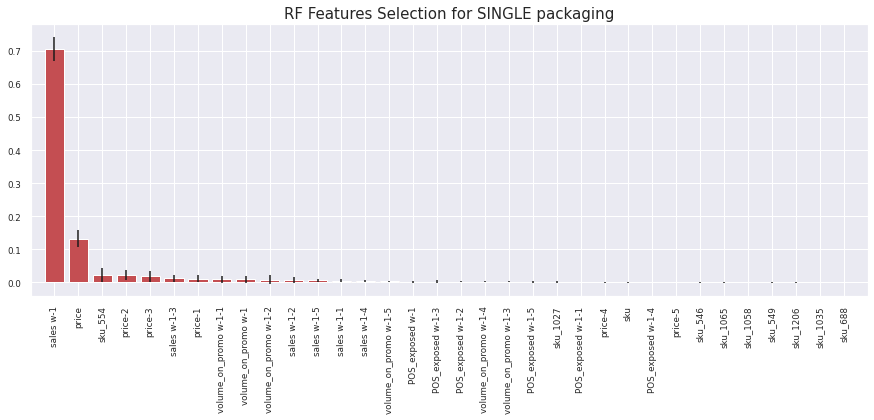

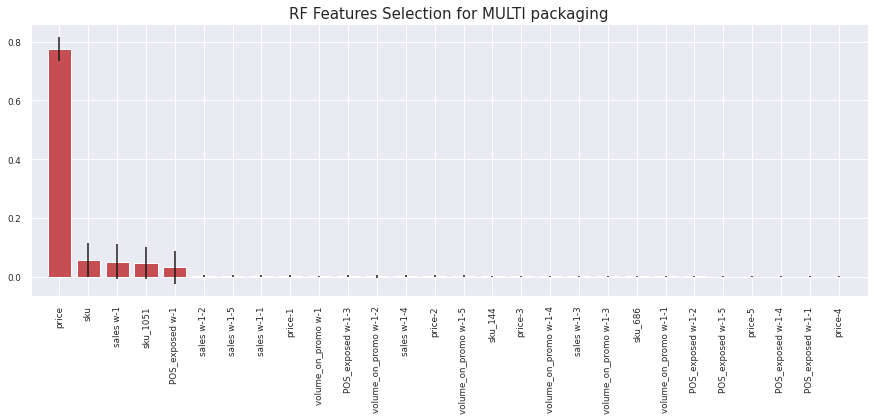

In [ ]:
i = 0
titles = ["RF Features Selection for SINGLE packaging", "RF Features Selection for MULTI packaging"]
for frame in [sales_data_single, sales_data_multi]:
  forest = RandomForestRegressor(n_estimators=100, random_state=1234)

  forest.fit(X=frame.drop(columns=["target"], axis=1), y=frame["target"])
  num_of_features = frame.drop(columns=["target"], axis=1).shape[1]

  # Plot the features and their score according to the Random Forest
  importances = forest.feature_importances_
  std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
  indices = np.argsort(importances)[::-1]
  plot_features = []
  plot_values = []
  for index in indices:
    plot_features.append(frame.drop(columns=["target"], axis=1).columns[index])
    plot_values.append(importances[index])

  plt.figure(figsize=(15, 5))
  plt.title(titles[i], fontdict={"fontsize":15})
  i += 1
  plt.bar(range(num_of_features), plot_values, color="r", yerr=std[indices], align="center")
  plt.xticks(range(num_of_features), plot_features, rotation=90)
  plt.xlim([-1, num_of_features])
  plt.show()

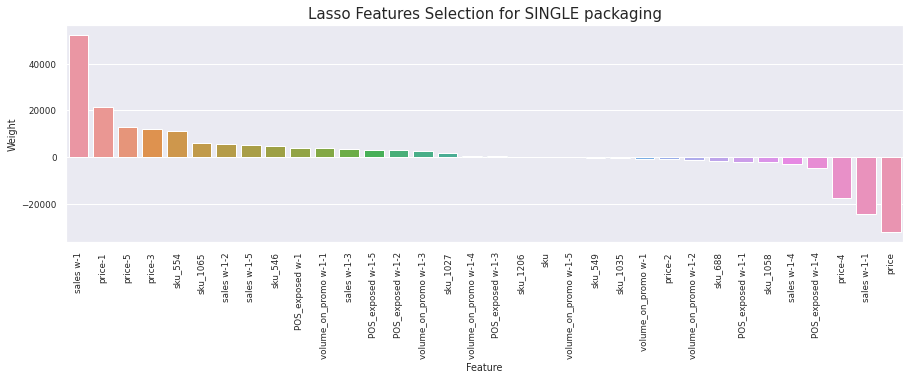

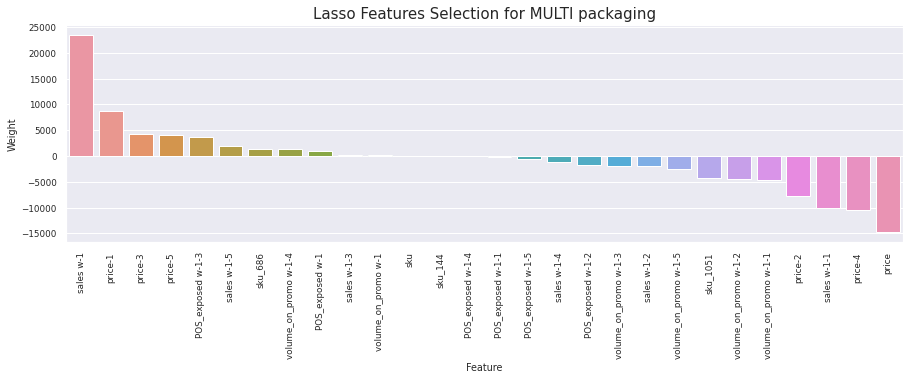

In [ ]:
i = 0
titles = ["Lasso Features Selection for SINGLE packaging", "Lasso Features Selection for MULTI packaging"]
features_coefficients = []
for frame in [sales_data_single, sales_data_multi]:
  std_scaler = StandardScaler()
  scaled_sales_data = std_scaler.fit_transform(X=frame.drop(columns=["target"], axis=1))

  # fit a new Lasso model for features selection with the normalize data frame
  lasso_model = Lasso(alpha=10, max_iter=5000, random_state=12323)
  lasso_model.fit(scaled_sales_data, y=frame["target"])
  lr_coefficients = pd.DataFrame({'Variable':frame.drop(columns=["target"], axis=1).columns, 'Coefficient':lasso_model.coef_}).sort_values(by=['Coefficient'],ascending=False)
  features_coefficients.append(lr_coefficients.copy())
  plt.figure(figsize=(15, 4))
  sns.barplot(x='Variable',y='Coefficient',data=lr_coefficients);
  plt.xticks(rotation=90)
  plt.title(titles[i], fontdict={"fontsize":15})
  plt.xlabel("Feature")
  i += 1
  plt.ylabel("Weight");

For both the models, the two more relevant **sku**s are 554 for the SINGLE packaging, and 1051 for the MULTI packaging. In both cases, the **sku**s correspond to a time series which is extreme for the context (i.e., **sku** 554 indentifies the lowest time series among all of those of SINGLE-**pack** products). By the way, as expected, the **price** is always one of the most relevant features, as well as the sales at the previous week. 
Let's check now the performances of a random forest in predicting the sales of both SINGLE and MULTI pack products.

## SINGLE-Pack Products' Sales Forecasting
We try here different models to predict the sales of ALL the products which present a SINGLE **pack** type, starting with Random Forests. We can make the threshold $\delta$ for features selection varying to compare the performances w.r.t. the number of features considerd:

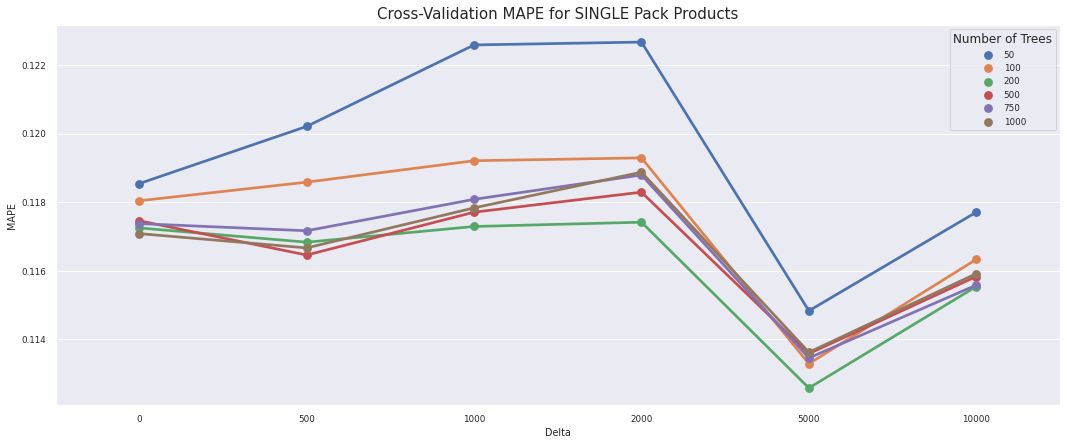

In [ ]:
# Takes about 1 hour
features_coefficients_single = features_coefficients[0]
trees = [50, 100, 200, 500, 750, 1000]
deltas = [0, 500, 1000, 2000, 5000, 10000]
mape_on_validation = []
for trees_nr in trees:
  for delta in deltas:
    delta_features = features_coefficients_single[(features_coefficients_single["Coefficient"] > delta) | (features_coefficients_single["Coefficient"] < -delta)]["Variable"]
    forest = RandomForestRegressor(random_state=1234, n_estimators=trees_nr)
    cv_mape, predictions = walk_forward_x_validation(estimator=forest, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_single,
                                        features=delta_features,
                                        target_feature="target")
    mape_on_validation.append([trees_nr, delta, cv_mape])

forest_performance = pd.DataFrame(mape_on_validation, columns=["Number of Trees", "Delta", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(18, 7))
plt.title("Cross-Validation MAPE for SINGLE Pack Products", fontdict={"fontsize":15})
sns.pointplot(x="Delta", y="MAPE", data=forest_performance, hue="Number of Trees");

Even though the performances are comparable, 50 trees are too few to improve the outcome of the a Random Forest mape-wise. On the other hand, if the features we consider are reduced enough ($\delta = 5000$), we can achieve good results with 200 trees.

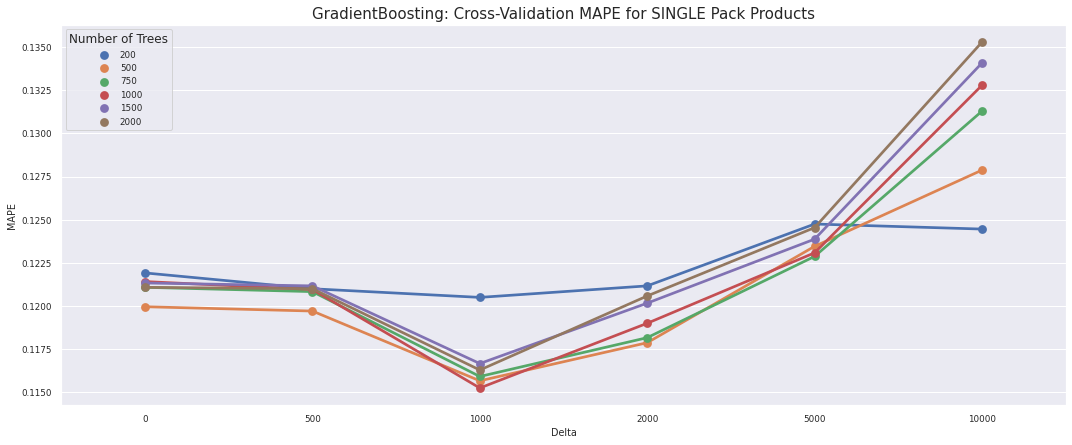

In [ ]:
# Takes about 1 hour
features_coefficients_single = features_coefficients[0]
trees = [200, 500, 750, 1000, 1500, 2000]
deltas = [0, 500, 1000, 2000, 5000, 10000]
mape_on_validation = []
for trees_nr in trees:
  for delta in deltas:
    delta_features = features_coefficients_single[(features_coefficients_single["Coefficient"] > delta) | (features_coefficients_single["Coefficient"] < -delta)]["Variable"]
    boost = GradientBoostingRegressor(random_state=1234, n_estimators=trees_nr)
    cv_mape, predictions = walk_forward_x_validation(estimator=boost, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_single,
                                        features=delta_features,
                                        target_feature="target")
    mape_on_validation.append([trees_nr, delta, cv_mape])

forest_performance = pd.DataFrame(mape_on_validation, columns=["Number of Trees", "Delta", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(18, 7))
plt.title("GradientBoosting: Cross-Validation MAPE for SINGLE Pack Products", fontdict={"fontsize":15})
sns.pointplot(x="Delta", y="MAPE", data=forest_performance, hue="Number of Trees");

The GradientBoosting regression seems to achieve good results also if more features are considered and, mape-wise, the performance are comparable to those obrained with the Random Forests.

## MULTI-Pack Products' Sales Forecasting
We complete here the sales predictions adding the MULTI-Pack products. As we will derive shortly, the performances are way worse, for reasons that will be explained shortly.

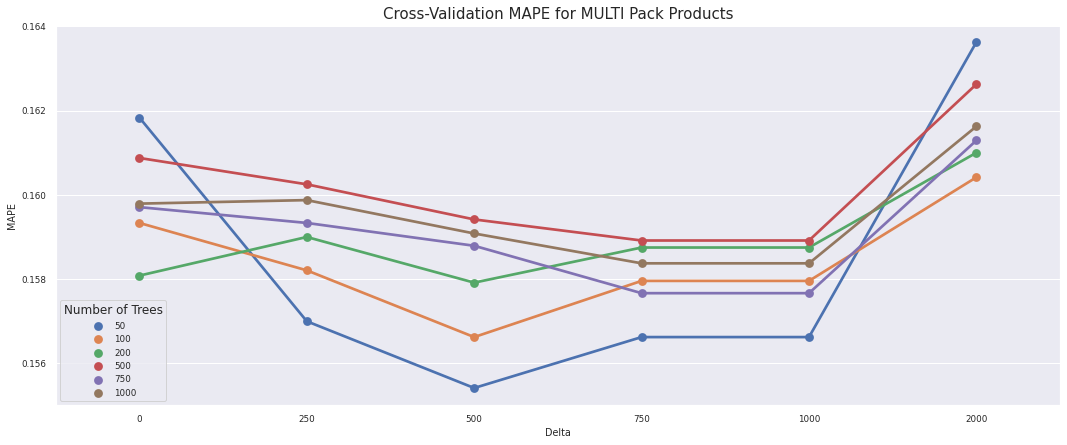

In [ ]:
features_coefficients_multi = features_coefficients[1]
trees = [50, 100, 200, 500, 750, 1000]
deltas = [0, 250, 500, 750, 1000, 2000]
mape_on_validation = []
for trees_nr in trees:
  for delta in deltas:
    delta_features = features_coefficients_multi[(features_coefficients_multi["Coefficient"] > delta) | (features_coefficients_multi["Coefficient"] < -delta)]["Variable"]
    forest = RandomForestRegressor(random_state=1234, n_estimators=trees_nr)
    cv_mape, predictions = walk_forward_x_validation(estimator=forest, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_multi,
                                        features=delta_features,
                                        target_feature="target")
    mape_on_validation.append([trees_nr, delta, cv_mape])

forest_performance = pd.DataFrame(mape_on_validation, columns=["Number of Trees", "Delta", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(18, 7))
plt.title("Cross-Validation MAPE for MULTI Pack Products", fontdict={"fontsize":15})
sns.pointplot(x="Delta", y="MAPE", data=forest_performance, hue="Number of Trees");

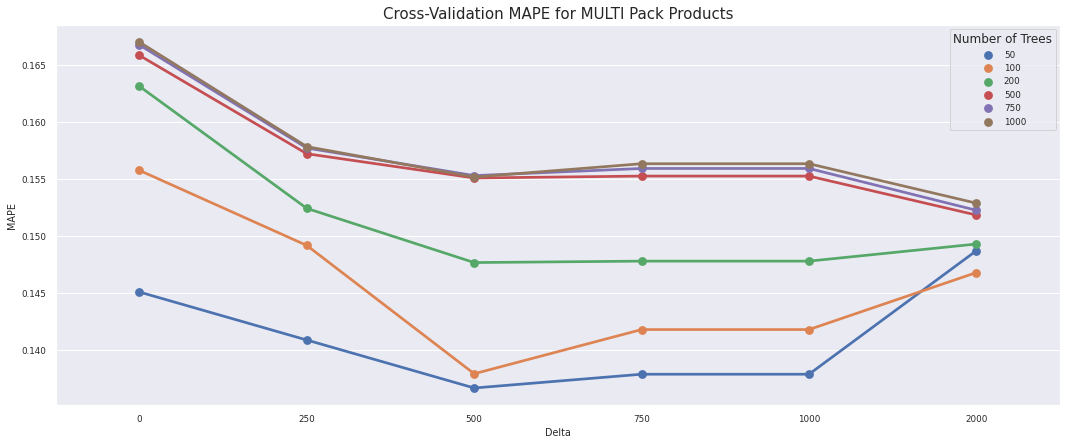

In [ ]:
features_coefficients_multi = features_coefficients[1]
trees = [50, 100, 200, 500, 750, 1000]
deltas = [0, 250, 500, 750, 1000, 2000]
mape_on_validation = []
for trees_nr in trees:
  for delta in deltas:
    delta_features = features_coefficients_multi[(features_coefficients_multi["Coefficient"] > delta) | (features_coefficients_multi["Coefficient"] < -delta)]["Variable"]
    boost = GradientBoostingRegressor(random_state=1234, n_estimators=trees_nr)
    cv_mape, predictions = walk_forward_x_validation(estimator=boost, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_multi,
                                        features=delta_features,
                                        target_feature="target")
    mape_on_validation.append([trees_nr, delta, cv_mape])

forest_performance = pd.DataFrame(mape_on_validation, columns=["Number of Trees", "Delta", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(18, 7))
plt.title("Cross-Validation MAPE for MULTI Pack Products", fontdict={"fontsize":15})
sns.pointplot(x="Delta", y="MAPE", data=forest_performance, hue="Number of Trees");

For MULTI-pack products we can see an higher MAPE, this is due to the fact that **the last peaks of the just mentioned time series are higher than those seen before by the tree-based ensamble method** we are using (check the time series plot for MULTI-Pack products), the random forests; this can generate problems in the predictions, it tipically ends up showing a flat behaviour in predicting sales higher or lower than what it has ever seen during training. **We can try to mitigate this problem by adopting a model which is not based on trees**, let's try a Ridge model:

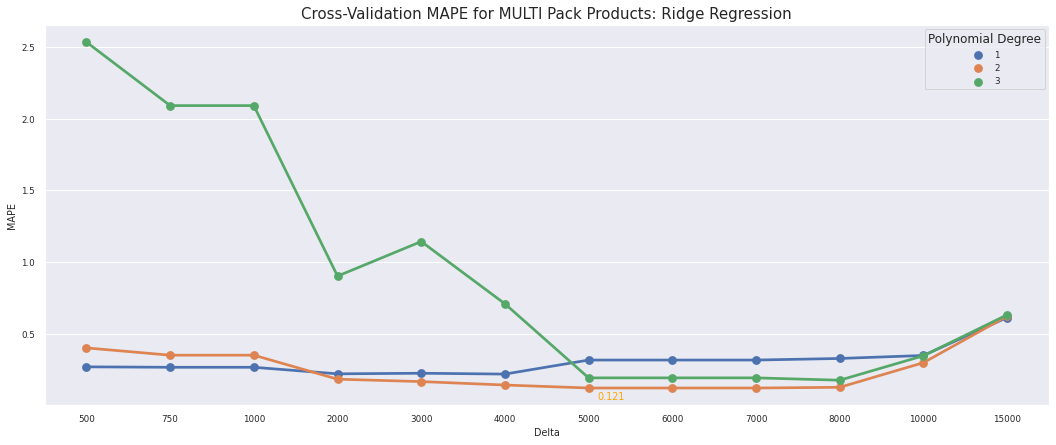

In [ ]:
features_coefficients_multi = features_coefficients[1]
poly_degrees = [1, 2, 3]
deltas = [500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000, 15000]
mape_on_validation = []
for degree in poly_degrees:
  for delta in deltas:
    delta_features = features_coefficients_multi[(features_coefficients_multi["Coefficient"] > delta) | (features_coefficients_multi["Coefficient"] < -delta)]["Variable"]
    linear_model = Ridge(random_state=1234, alpha=1)
    cv_mape, predictions = walk_forward_x_validation(estimator=linear_model, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_multi,
                                        features=delta_features,
                                        target_feature="target",
                                        poly_degree=degree)
    mape_on_validation.append([degree, delta, cv_mape])

forest_performance = pd.DataFrame(mape_on_validation, columns=["Polynomial Degree", "Delta", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(18, 7))
plt.text(6.1, 0.04, "0.121", fontdict={"color":"orange"})
plt.title("Cross-Validation MAPE for MULTI Pack Products: Ridge Regression", fontdict={"fontsize":15})
sns.pointplot(x="Delta", y="MAPE", data=forest_performance, hue="Polynomial Degree");

As expected, the worsening in performances shown by trees-based method is sufficiently reduced here, obtaining performances comparable to those concerning SINGLE-Pack products. Let's explore a little the Ridge regression approach on the basis of the regularization coefficient $\alpha$:

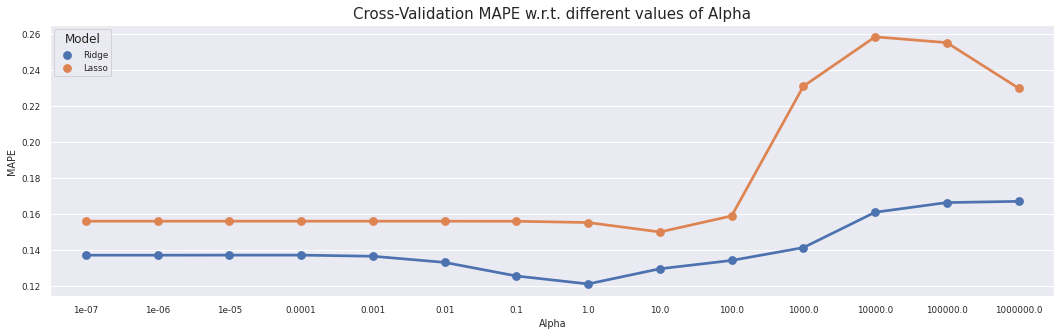

In [ ]:
alphas = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
mape_on_validation = []
delta = 5000
delta_features = features_coefficients_multi[(features_coefficients_multi["Coefficient"] > delta) | (features_coefficients_multi["Coefficient"] < -delta)]["Variable"]
for alpha in alphas:
  for model in [Ridge(random_state=1234, alpha=alpha), Lasso(random_state=1234, alpha=alpha)]:
    linear_model = model
    cv_mape, predictions = walk_forward_x_validation(estimator=linear_model, 
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data_multi,
                                        features=delta_features,
                                        target_feature="target",
                                        poly_degree=2)
    if isinstance(model, Lasso):
      mape_on_validation.append(["Lasso", alpha, cv_mape])
    elif isinstance(model, Ridge):
      mape_on_validation.append(["Ridge", alpha, cv_mape])

linear_performance = pd.DataFrame(mape_on_validation, columns=["Model", "Alpha", "MAPE"]).sort_values(by=['MAPE'], ascending=True)
plt.figure(figsize=(18, 5))
plt.title("Cross-Validation MAPE w.r.t. different values of Alpha", fontdict={"fontsize":15})
sns.pointplot(x="Alpha", y="MAPE", data=linear_performance, hue="Model");

We included also the Lasso to compare the performances. As expected, the Lasso model sets the weights to zero much faster that Ridge for high values of $\alpha$, worsening the performance earlier. By the way, the best results for the Ridge Regressor are achieved with $\alpha=1$. In conclusion:

* The Random Forest model achieves good result for SINGLE-pack products, in particular, with $\delta=5000$ we are taking into account a lot of features, including: **sales w-[1:5]**, **price-[0:4]**, **sku_554**, **sku_1065**;
* The Ridge Regression is a better option in case of MULTI-pack products with $\alpha=1$, in particular, with $\delta=5000$ we are taking into account: **sales w-[1:2]**, **price-[0:4]**

---
# Stacking for SINGLE-Pack Products: Random Forest, GBoosting
We try here to combine more than one regressor, in particular, we put together a Random Forest and Gboost Regressors to compute the final prediction. In particular, as a meta-learner, rather than just taking the mean, we can use a Linear Regression model and let it compute the proper weight for each prediction. We start defining the time-series cross-validation function for ensemble methods:




In [76]:
def walk_forward_x_validation_stacking(estimators, meta_estimator, meta_features, start_date, data, features, target_feature, poly_degree=1, verbose=False):
  dates = list(data[start_date:].index.unique())
  mapes = []
  predictions_list = []
  for k in range(len(dates) - 1):
    estimator_preds = []
    curr_date = str(dates[k].year) + "-" + str(dates[k].month) + "-" + str(dates[k].day)
    next_date = str(dates[k + 1].year) + "-" + str(dates[k + 1].month) + "-" + str(dates[k + 1].day)
    for estimator in estimators:
      estimator_index = estimators.index(estimator)
      estimator.fit(X=data[features[estimator_index]][:curr_date], y=data[target_feature][:curr_date])
      estimator_preds.append(estimator.predict(X=data[features[estimator_index]][:curr_date]))

    # for every product, take the predictions provided by the estimators (for each date), then append the meta_features
    # to create the dataset for the meta-learner
    meta_learner_data = []
    for product_index in range(len(estimator_preds[0])):
      meta_learner_features = [estimator_preds[i][product_index] for i in range(len(estimator_preds))]
      if poly_degree > 1:
        transformer = PolynomialFeatures(degree=poly_degree, include_bias=False)
        poly_data = list(transformer.fit_transform(X=[data[meta_features][:curr_date].values[product_index]]))
        meta_learner_features.extend(poly_data[0])
      else:
        meta_learner_features.extend(list(data[meta_features][:curr_date].values)[product_index])
      meta_learner_data.append(meta_learner_features.copy())
    
    meta_learner_data_predictions = []
    estimator_preds_next = []
    for estimator in estimators:
      estimator_index = estimators.index(estimator)
      estimator_preds_next.append(estimator.predict(X=data[features[estimator_index]][next_date:next_date]))
    
    for product_index in range(len(estimator_preds_next[0])):
      meta_learner_features = [estimator_preds_next[i][product_index] for i in range(len(estimator_preds_next))]
      if poly_degree > 1:
        transformer = PolynomialFeatures(degree=poly_degree, include_bias=False)
        poly_data = list(transformer.fit_transform(X=[data[meta_features][next_date:next_date].values[product_index]]))
        meta_learner_features.extend(poly_data[0])
      else:
        meta_learner_features.extend(list(data[meta_features][next_date:next_date].values)[product_index])
      
      meta_learner_data_predictions.append(meta_learner_features.copy())

    meta_estimator.fit(X=meta_learner_data, y=data[target_feature][:curr_date])
    meta_estimator_predictions = meta_estimator.predict(X=meta_learner_data_predictions)
    predictions_list.append(meta_estimator_predictions)
    mape = MAPE(data[target_feature][next_date:next_date], meta_estimator_predictions)
    mapes.append(mape)
    if verbose:
      print(next_date, mape)

  predictions_frame = pd.DataFrame(predictions_list, columns=data["sku"].unique())
  predictions_frame.set_index(data[str(dates[1].year) + "-" + str(dates[1].month) + "-" + str(dates[1].day):].index.unique(), inplace=True)

  return np.mean(mapes), predictions_frame

We can try different values of $\delta$ for each model and different number of estimators in both the Random Forest and Gradient Boosting Regressors:

In [ ]:
deltas = [(10, 50), (100, 500), (1000, 5000)]
trees_nr = [(200, 200), (200, 400), (400, 200), (400, 400), (200, 1000), (400, 1000), (1000, 200), (1000, 400),
            (1000, 1000)]
meta_learner = LinearRegression(fit_intercept=True)
mapes = []
for delta_couple in deltas:
  for trees_couple in trees_nr:
    delta_features_rf = features_coefficients_single[(features_coefficients_single["Coefficient"] > delta_couple[0]) | (features_coefficients_single["Coefficient"] < -delta_couple[0])]["Variable"]
    delta_features_boosting = features_coefficients_single[(features_coefficients_single["Coefficient"] > delta_couple[1]) | (features_coefficients_single["Coefficient"] < -delta_couple[1])]["Variable"]
    forest = RandomForestRegressor(n_estimators=trees_couple[0], random_state=1234)
    boost = GradientBoostingRegressor(n_estimators=trees_couple[1], random_state=1234, alpha=0.1)
    estimators = [forest, boost]
    cv_mape, predictions = walk_forward_x_validation_stacking(estimators, meta_learner, [], "2019", sales_data_single, [delta_features_rf, delta_features_boosting], "target", poly_degree=1)
    mapes.append([delta_couple[0], delta_couple[1], trees_couple[0], trees_couple[1], cv_mape])

single_stacking_frame = pd.DataFrame(mapes, columns=["Delta_rf", "Delta_boosting", "Trees_rf", "Trees_boosting", "Cv-MAPE"]).sort_values(by=['Cv-MAPE'], ascending=True)

In [ ]:
single_stacking_frame.head()

,Delta_rf,Delta_boosting,Trees_rf,Trees_boosting,Cv-MAPE
18,1000,5000,200,200,0.112625
11,100,500,400,200,0.113125
15,100,500,1000,200,0.113167
20,1000,5000,400,200,0.113250
6,10,50,1000,200,0.113375


As we have shown, we are able to achieve good performances with different values of $\delta$ for the two models and using Linear Regression as the meta-learner. Being the MULTI-Pack products $\frac{1}{4}$ w.r.t. all the products and the SINGLE-Pack ones $\frac{3}{4}$ and for each product we have the same number of examples in our training set, the overall performances can be computes as: $$\frac{3}{4}mape_{single} + \frac{1}{4}mape_{multi} = 0.114$$

---

# A simpler and unique model for sales forecast
In this final section we explore the possibility to develop a simpler model, with much less features, which takes into account all the products data at the same time, avoiding the split between SINGLE and MULTI pack products and therefore the development of two separated models. In particular:

* Putting all the products data in a single model may have the model better predict the sales in general, that is, there may be some common information between SINGLE and MULTI pack products that can be leveraged by the unique model.
* The models studied so far seems to be good but rely on a lot of features that **may not be available at prediction time** and therefore the model cannot be used in practice. We are going to build here a model which uses only features that are available at prediction time, with the exception of **sales w-1**, that will be predicted and inputed at each time step in the prediction.

In [28]:
sales_data = pd.read_csv('/content/drive/My Drive/DMTM_Project_Data/train.csv')
sales_data = sales_data[sales_data["scope"] == 1] # Consider only the products of interest
for i, row in sales_data.iterrows():
  date = row["Unnamed: 0"]
  date_wo_day_of_week = date[3:] # Remove WE since all days of the week are the same
  sales_data.at[i, "Unnamed: 0"] = date_wo_day_of_week

# Set the date as the index of the dataframe
sales_data["Unnamed: 0"] = pd.to_datetime(sales_data["Unnamed: 0"])
sales_data.set_index(sales_data["Unnamed: 0"], inplace=True)
sales_data.drop(columns=["Unnamed: 0", "scope"], axis=1, inplace=True)
sales_data.index.rename("date", inplace=True)

# One-hot encode the skus but keeping the original values for prediction purposes
skus = sales_data["sku"]
sales_data = pd.get_dummies(sales_data, columns=["sku", "pack"]).drop(columns=["size (GM)"], axis=1)
sales_data["sku"] = skus

# Consider a total of 3 previous lags for the sales
for lag in range(1, 3):
  sales_data["sales w-" + str(lag + 1)] = sales_data["sales w-1"].shift(lag)

# One-hot encode the brand of the products
sales_data = pd.get_dummies(sales_data, columns=["brand"])

# Add the mean of the three previous sales
sales_data["sales_rolling_3"] = sales_data["sales w-1"].rolling(3, min_periods=1).mean()

# Add two lags in the past for the planned price
sales_data["price w-1"] = sales_data["price"].shift()
sales_data["price w-2"] = sales_data["price w-1"].shift()

# Add the day and the week of the year. We do not one-hot encode them being the number of resulting columns too large
sales_data["day of the year"] = sales_data.index.dayofyear
sales_data["week of the year"] = sales_data.index.weekofyear

sales_data.dropna(inplace=True)

The features will include:

* Three lags in the past of the sales, to have an idea of the trend followed in the previous three weeks,
* Two lags in the past of the planned **price**, which is the better feature to predict the sales of the next wee. In particular, being it PLANNED, we assume to have it available for the incoming weeks
* The number of shops in which the product will be exposed
* The volume of products in promo at each of the incoming weeks
* The one-hot encoded **sku**, to distinguish among products with different time series on sales 
* One-hot encoded **brand** and **pack**, to split the products in the way we shown in the beginning, which represent an optimal split in terms of similarity among time series of sales
* The day and week of the year, to have an idea on what happens in that moment of the year in general. **We decided to not one-hot encode those features because of the huge number of resulting columns that would be generated**.

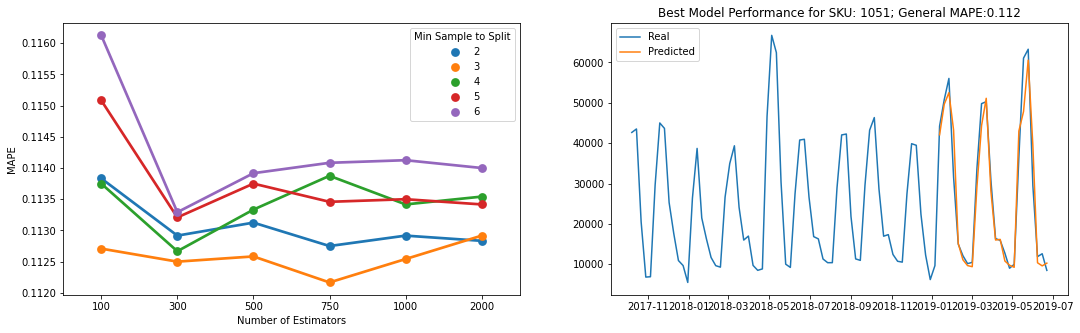

In [59]:
sample_splits = [2, 3, 4, 5, 6]
num_of_trees = [100, 300, 500, 750, 1000, 2000]
all_models_predictions = []
cv_mapes = []
for min_sample_split in sample_splits:
  for trees in num_of_trees:
    rf = ExtraTreesRegressor(n_estimators=trees, random_state=1234, criterion='mse', min_samples_split=min_sample_split)
    cv_mape, predictions = walk_forward_x_validation(estimator=rf,
                                        start_date="2019", # cross-validate starting from 2019
                                        data=sales_data,
                                        features=sales_data.drop(columns=["target", "scope", "pack_MULTI", "brand_BRAND2", "sku"], axis=1).columns,
                                        target_feature="target")
    cv_mapes.append([trees, min_sample_split, cv_mape])
    all_models_predictions.append(predictions)

performance_frame = pd.DataFrame(cv_mapes, columns=["Number of Estimators", "Min Sample to Split", "MAPE"])
best_predictions = all_models_predictions[np.argmin(performance_frame["MAPE"].values)]

# Plot some analytics
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 2, 1)
sns.pointplot(data=performance_frame, x="Number of Estimators", y="MAPE", hue="Min Sample to Split", ax=ax)
ax = fig.add_subplot(1, 2, 2)
ax.plot(sales_data[sales_data["sku"] == 1051]["target"]["2017-10":])
ax.plot(best_predictions[1051])
ax.legend(["Real", "Predicted"])
ax.set_title("Best Model Performance for SKU: 1051; General MAPE:" + str(round(performance_frame["MAPE"].min(), 3)))
plt.show();

 # Stacking Regression: Unique Model
 Lastly, we can try to stack some different models to improve the performances of an Extreme Random Forest. In particular, in addition to the latter, we add here a GradientBoosting and a Random Forest regressors. **Rather than simply computing the mean of the three predictions, we adopt a Linear Regression model as the meta-learner and let it predict the proper weights for each prediction**.
We peform a little greedy search in the hyperparameters' space:



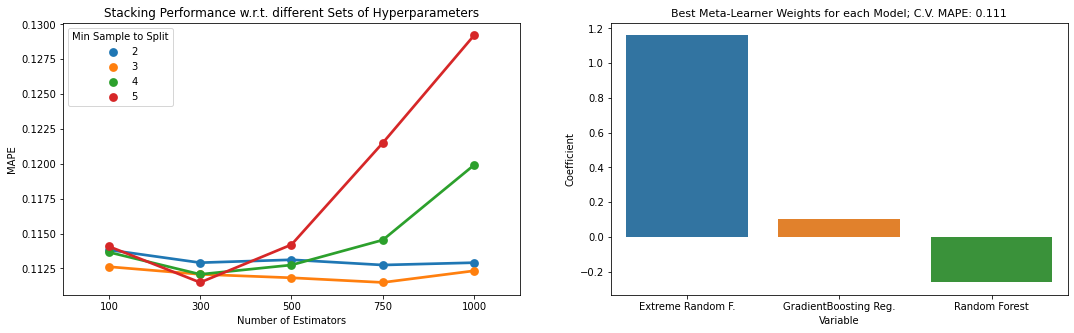

In [94]:
# Takes about 1 hour and 46 minutes
stacking_data = []
meta_learner_coefficients = []
meta_estimator = LinearRegression(fit_intercept=False) # Rather than computing the mean, find the optimal weights for the prediction

for trees in [100, 300, 500, 750, 1000]:
  for min_split in [2, 3, 4, 5]:
    models = [ExtraTreesRegressor(n_estimators=trees, random_state=1234, min_samples_split=min_split),
              GradientBoostingRegressor(n_estimators=trees, random_state=1234, alpha=0.01, min_samples_split=min_split),
              RandomForestRegressor(n_estimators=trees, random_state=1234, min_samples_split=min_split)]
    stacking_regressor = StackingRegressor(estimators=models, final_estimator=meta_estimator)

    cv_mape, predictions = walk_forward_x_validation_stacking(estimators=models, 
                                                              meta_estimator=meta_estimator, 
                                                              meta_features=[],
                                                              start_date="2019", 
                                                              data=sales_data, 
                                                              features=[sales_data.drop(columns=["target", "scope", "pack_MULTI", "brand_BRAND2", "sku"], axis=1).columns]*3, 
                                                              target_feature="target", 
                                                              verbose=False)
    stacking_data.append([trees, min_split, cv_mape])
    meta_learner_coefficients.append(meta_estimator.coef_)

performance_frame = pd.DataFrame(stacking_data, columns=["Number of Estimators", "Min Sample to Split", "MAPE"])
# Plot some analytics
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 2, 1)
sns.pointplot(data=performance_frame, x="Number of Estimators", y="MAPE", hue="Min Sample to Split", ax=ax)
ax.set_title("Stacking Performance w.r.t. different Sets of Hyperparameters")
ax = fig.add_subplot(1, 2, 2)
best_meta_learner_coef = meta_learner_coefficients[np.argmin(performance_frame["MAPE"].values)]
meta_coefficients = pd.DataFrame({'Variable':["Extreme Random F.", "GradientBoosting Reg.", "Random Forest"], 'Coefficient':best_meta_learner_coef}).sort_values(by=['Coefficient'],ascending=False)
sns.barplot(x='Variable', y='Coefficient', data=meta_coefficients, ax=ax)
ax.set_title("Best Meta-Learner Weights for each Model; C.V. MAPE: " + str(round(performance_frame["MAPE"].min(), 3)), fontdict={"fontsize":11})
plt.show();

As we can see from the picture from the left, the largest weight is associated to the Extreme Random Forest regressor, that is, **it is the most accurate predictor according to the meta-learner weights**. Indeed, the best results we obtained, mape-wise, are approximately the same as the results achieved by the Extreme random forest alone. Interestingly, being the weight associated to the random forest prediction negative and being the **target** values always positive, **we may think that the prediction associated to the random forest is used as a correction to the predictions of the Extreme Random Forest and GradientBoosting**. In terms of absolute values of the weights, the GradientBoosting seems to be the less impactful model.

We can check how the weights of the meta-learner are distributed by means of a violin-plot:

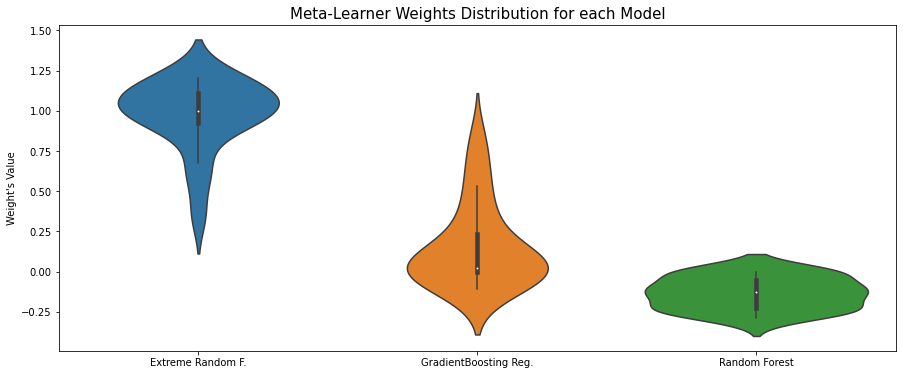

In [104]:
coeffs = pd.DataFrame(meta_learner_coefficients, columns=["Extreme Random F.", "GradientBoosting Reg.", "Random Forest"])
plt.figure(figsize=(15, 6))
plt.title("Meta-Learner Weights Distribution for each Model", fontdict={"fontsize":15})
plt.ylabel("Weight's Value")
sns.violinplot(data=coeffs);

The distributions shown in the violin-plot confirm what we have discussed for the optimal case just mentioned. the Extreme Random Forest is the most impactful model. 

In conclusion, we built a unified model for all the products, including also information regarding the **brand** and the **pack** type. I think this model represents a valid improvement w.r.t. the two separated models discussed previously for two reasons:

1. **The simplicity**: the unified model presented here is way simpler w.r.t. the two separated models (one for each **pack** type);
2. **The better performance**: the unified simpler model is able to provide a slightly better performance. This is a very good result if we consider that having to similar models in terms of performance, but one of the two is simpler, the simpler one has in general to be preferred.

We are going to use this last model we developed as the final model to be tested on the test set, saved in the *x_test.csv* file.

---

# Model Testing and Final Score
We can now test the model we developed with the actual test set. In particular, we are using a unified Stacking Regressor. First we need to prepare the test-set, introducing previous lags of the features and all the other kind of features as we have done in the training set. 

In [ ]:
# Test set preparation
sales_data_test = pd.read_csv('/content/drive/My Drive/DMTM_Project_Data/x_test.csv')
for i, row in sales_data_test.iterrows():
  date = row["Unnamed: 0"]
  date_wo_day_of_week = date[3:] # Remove WE since all days of the week are the same
  sales_data_test.at[i, "Unnamed: 0"] = date_wo_day_of_week

# Set the date as index and drop the useless columns
sales_data_test["Unnamed: 0"] = pd.to_datetime(sales_data_test["Unnamed: 0"])
sales_data_test.set_index(sales_data_test["Unnamed: 0"], inplace=True)
sales_data_test.drop(columns=["Unnamed: 0", "scope", "size (GM)"], axis=1, inplace=True)
sales_data_test.index.rename("date", inplace=True)

prepared_products_frames = []
for sku in sales_data["sku"].unique():
  # For each sku, add the features combining it with the final portion of the training set
  target_sku_sales_test = sales_data_test[sales_data_test["sku"] == int(sku)]
  sales_data_target_sku = sales_data[sales_data["sku"] == sku][["sku", "pack", "brand", "price", "POS_exposed w-1", "volume_on_promo w-1", "sales w-1"]]
  joint_target_sku_frame = pd.concat([sales_data_target_sku, target_sku_sales_test]) # Add previous values considering the training set
  joint_target_sku_frame["price w-1"] = joint_target_sku_frame["price"].shift()
  joint_target_sku_frame["price w-2"] = joint_target_sku_frame["price w-1"].shift()
  joint_target_sku_frame["sales_rolling_3"] = joint_target_sku_frame["sales w-1"].rolling(3, min_periods=1).mean()
  joint_target_sku_frame["day of the year"] = joint_target_sku_frame.index.dayofyear
  joint_target_sku_frame["week of the year"] = joint_target_sku_frame.index.weekofyear
  for lag in range(1, 3):
    joint_target_sku_frame["sales w-" + str(lag + 1)] = joint_target_sku_frame["sales w-1"].shift(lag)

  prepared_products_frames.append(joint_target_sku_frame["2019-06-29":]) # Test set starts from date 29 June 2019
sales_data_test = pd.concat(prepared_products_frames) # Rebuild a dataframe with all the test frames of each product
test_skus = sales_data_test["sku"]
sales_data_test = pd.get_dummies(sales_data_test, columns=["sku", "pack", "brand"])
sales_data_test["sku"] = test_skus

*sales_data_test* represents our test set with all the features we considered in the training set. We are now required to perform a 25-steps ahead prediction for each **sku**. At prediction time, we don't have access to **target** values since it is exactly what we are predicting. The prediction procedure for the following 25 weeks will follow these steps:
1. Train the model with data up to week **w-1**; predict the **target** for the immediately next week, we can do this having access to **sales w-1**
2. Set **target** of the current sample as the predicted value from point 1.
3. Set **sales w-1** of the next sample as the predicted value from point 1.
4. Set **sales w-2** and **sales w-3** accordingly.
5. Repeat from 1. with the next sample, that sample of week **w+1**

The following function works exactly this way:

In [71]:
def predict_stacking(estimators, meta_estimator, meta_features, start_date, data, features, target_feature, poly_degree=1, verbose=0):
  dates = list(data[start_date:].index.unique())
  predictions = []
  trained = False
  for k in range(len(dates) - 1):
    estimator_preds = []
    curr_date = str(dates[k].year) + "-" + str(dates[k].month) + "-" + str(dates[k].day)
    next_date = str(dates[k + 1].year) + "-" + str(dates[k + 1].month) + "-" + str(dates[k + 1].day)
    if not trained:
      for estimator in estimators:
        estimator_index = estimators.index(estimator)
        estimator.fit(X=data[features[estimator_index]][:curr_date], y=data[target_feature][:curr_date])
        estimator_preds.append(estimator.predict(X=data[features[estimator_index]][:curr_date]))
      # for every product, take the predictions provided by the estimators (for each date), then append the meta_features
      # to create the dataset for the meta-learner
      meta_learner_data = []
      for product_index in range(len(estimator_preds[0])):
        meta_learner_features = [estimator_preds[i][product_index] for i in range(len(estimator_preds))]
        if poly_degree > 1:
          transformer = PolynomialFeatures(degree=poly_degree, include_bias=False)
          poly_data = list(transformer.fit_transform(X=[data[meta_features][:curr_date].values[product_index]]))
          meta_learner_features.extend(poly_data[0])
        else:
          meta_learner_features.extend(list(data[meta_features][:curr_date].values)[product_index])
        meta_learner_data.append(meta_learner_features.copy())

    meta_learner_data_predictions = []
    estimator_preds_next = []
    for estimator in estimators:
      estimator_index = estimators.index(estimator)
      estimator_preds_next.append(estimator.predict(X=data[features[estimator_index]][next_date:next_date]))
    
    # Prepare the data for the meta_learmer: in simple words, reshape the estimator_preds_next into a new array: meta_learner_data_predictions 
    for product_index in range(len(estimator_preds_next[0])):
      meta_learner_features = [estimator_preds_next[i][product_index] for i in range(len(estimator_preds_next))]
      if poly_degree > 1:
        transformer = PolynomialFeatures(degree=poly_degree, include_bias=False)
        poly_data = list(transformer.fit_transform(X=[data[meta_features][next_date:next_date].values[product_index]]))
        meta_learner_features.extend(poly_data[0])
      else:
        meta_learner_features.extend(list(data[meta_features][next_date:next_date].values)[product_index])
      
      meta_learner_data_predictions.append(meta_learner_features.copy())

    if not trained:
      trained = True
      meta_estimator.fit(X=meta_learner_data, y=data[target_feature][:curr_date])

    meta_estimator_predictions = meta_estimator.predict(X=meta_learner_data_predictions)

    # Overwrite target-dependent columns with predicted values
    data.at[next_date, "sales w-1"] = data.loc[curr_date, "target"].values
    data.at[next_date, "sales w-2"] = data.loc[curr_date, "sales w-1"].values
    data.at[next_date, "sales w-3"] = data.loc[curr_date, "sales w-2"].values
    data.at[next_date, "target"] = meta_estimator_predictions
    data["sales_rolling_3"] = (data["sales w-1"] + data["sales w-2"] + data["sales w-3"]) / 3
    # Save the predictions
    predictions.append(meta_estimator_predictions)

    if verbose == 1:
      print(next_date, "predictions completed.")

  result = pd.DataFrame(predictions, columns=data["sku"].unique())
  result.set_index(data[str(dates[1].year) + "-" + str(dates[1].month) + "-" + str(dates[1].day):str(dates[-1].year) + "-" + str(dates[-1].month) + "-" + str(dates[-1].day)].index.unique(), inplace=True)
  return result

We use here the stacking regressor with 750 trees for each estimator, as derived from the previous analysis. 

In [92]:
xfr = ExtraTreesRegressor(n_estimators=750, min_samples_split=3, random_state=1234)
gb = GradientBoostingRegressor(n_estimators=750, min_samples_split=3, random_state=1234)
rf = RandomForestRegressor(n_estimators=750, min_samples_split=3, random_state=1234)
models = [xfr, gb, rf]
meta_estimator = LinearRegression(fit_intercept=False)
# Create the test_frame as the concatenation of the training and the test sets
sales_data_test["target"] = 0
sales_data_test = sales_data_test[sales_data.columns]
test_frame = pd.concat([sales_data, sales_data_test])

predictions = predict_stacking(estimators=models, 
                               meta_estimator=meta_estimator,
                               meta_features=[],
                               start_date="2019-06-22", # start predicting from the date following 2019-06-22
                               data=test_frame,
                               features=[test_frame.drop(columns=["target", "pack_MULTI", "brand_BRAND2", "sku"], axis=1).columns]*3,
                               target_feature="target",
                               poly_degree=1,
                               verbose=0)


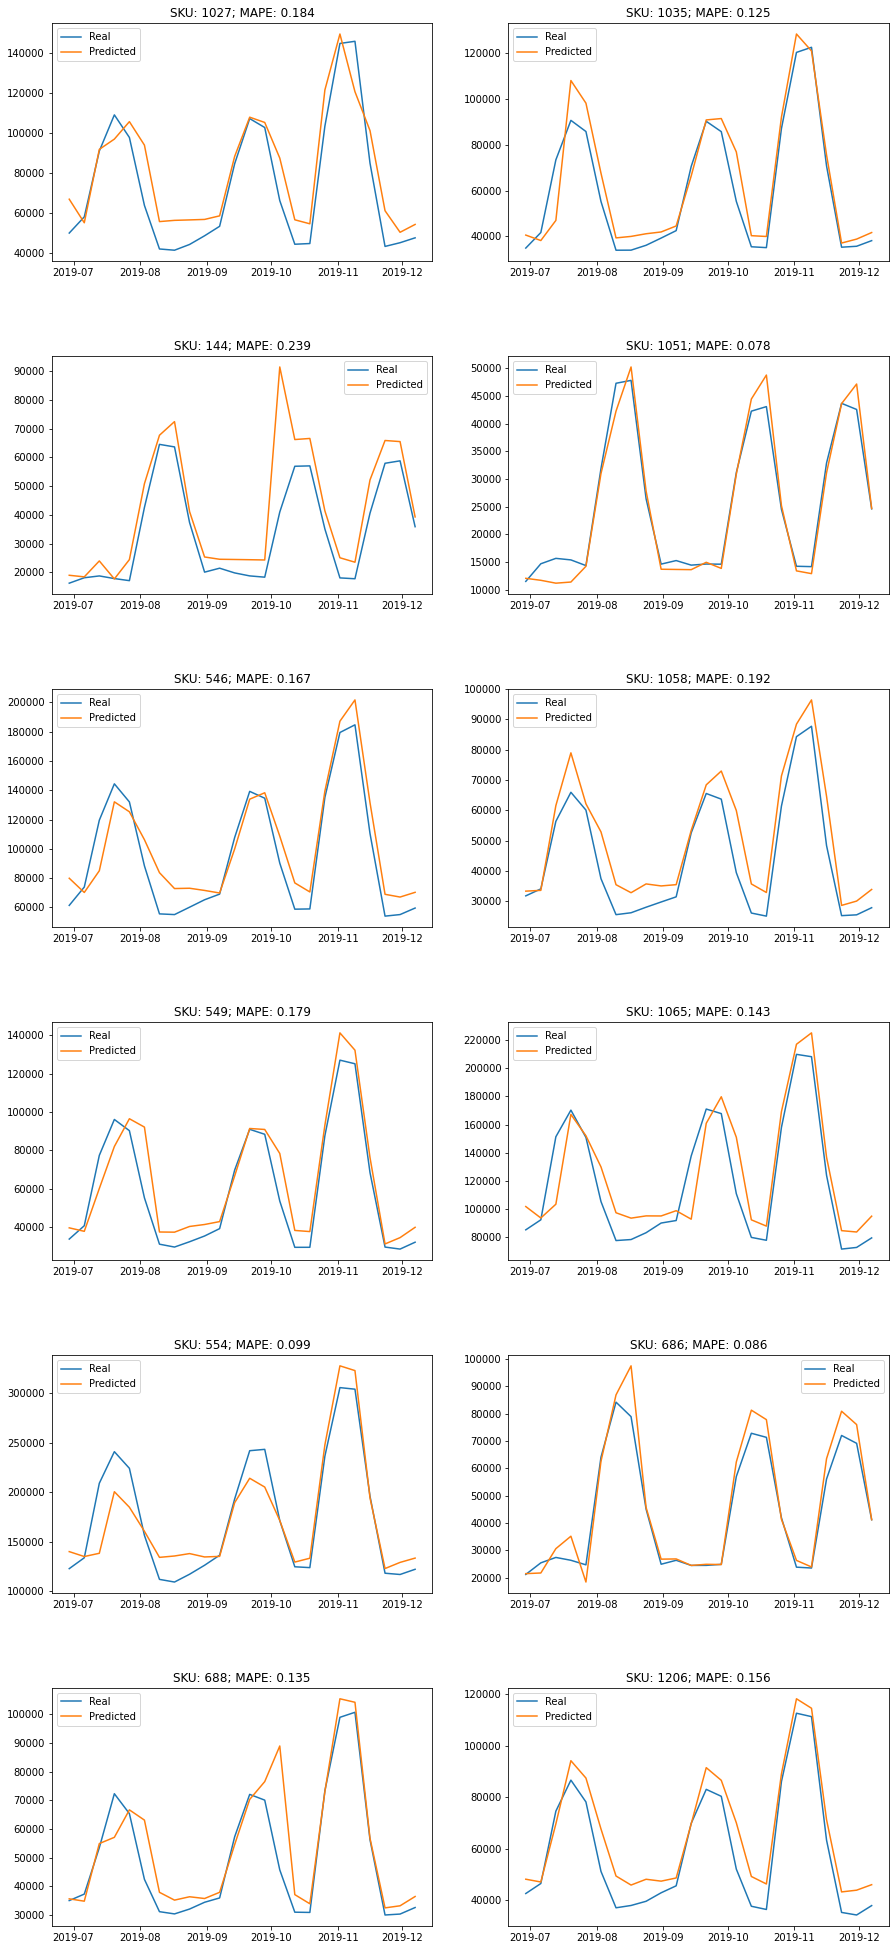

In [99]:
index = 1
fig = plt.figure(figsize=(15, 35))
fig.subplots_adjust(hspace=0.4)
for sku in predictions.columns:
  ax = fig.add_subplot(6, 2, index)
  ax.plot(sales_data_test[sales_data_test["sku"] == sku]["sales w-1"].shift(-1).dropna())
  ax.plot(predictions[sku][:24])
  ax.legend(["Real", "Predicted"])
  ax.set_title("SKU: " + str(sku) + "; MAPE: " + str(MAPE(sales_data_test[sales_data_test["sku"] == sku]["sales w-1"].shift(-1).dropna(),
                    predictions[sku][:24])))
  index += 1
plt.show();

As we can see, for some products the prediction is accurate, for other products the predictions are very weird. Overall, the stacking regressor is able to identify the periods with the sales spikes. Lastly, **the average mape we obtain with our model is**:



In [103]:
mapes = []
for sku in sales_data["sku"].unique():
  mape = MAPE(sales_data_test[sales_data_test["sku"] == sku]["sales w-1"].shift(-1).dropna(),
                    predictions[sku][:24])
  mapes.append(mape)
print("Average Testing MAPE:", round(np.mean(mapes), 4))

Average Testing MAPE: 0.1486
